In [1]:
import os

## Set directory
os.chdir('/home/ch416/GeneSys')

from genesys_train_v1 import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
## Conda Env pytorch-gpu on Workstation
## pytorch version
print(torch.__version__)
## scanpy
print(sc.__version__) 

2.2.0.dev20231009+cu118
1.9.5


In [3]:
## Genes considered/used (shared among samples) 
gene_list = pd.read_csv('./gene_list_1108.csv')

## Load Data

In [4]:
with open("./genesys_root_data.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
    
batch_size = 512
dataset = Root_Dataset(data['X_test'], data['y_test'])
loader = DataLoader(dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
train_dataset = Root_Dataset(data['X_train'], data['y_train'])
train_loader = DataLoader(train_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
val_dataset = Root_Dataset(data['X_val'], data['y_val'])
val_loader = DataLoader(val_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)

In [5]:
criterion = torch.nn.NLLLoss()
input_size = data['X_train'].shape[1]
## 10 cell types
output_size = 10
time_bins = 11
embedding_dim = 256
hidden_dim = 256
n_layers = 2
clip = 5
path = "./"
device = "cuda"
n_epochs = 100
train_on_gpu=True

In [6]:
model = ClassifierLSTM(input_size, output_size, embedding_dim, hidden_dim, n_layers).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
sch = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, threshold=0.05, verbose=True)

In [7]:
logger = {'tloss': [], 'val_acc': []}
best_val_acc = 0
best_loss = 10000
for epoch in range(n_epochs):
    h = model.init_hidden(batch_size)
    c, s = 0, 0
    pBar = tqdm(train_loader)
    model.train()
    for sample in pBar:
        h = tuple([each.data for each in h])
        x = sample['x'].to(device)
        y = sample['y'].to(device)
        optimizer.zero_grad()
        t = np.random.choice(time_bins-1)
        p, h = model.predict(x, h, t)
        model.get_belief(x, h)
        tdvae_loss = model.calculate_loss(t)
        nll_loss = criterion(p, y)
        loss = tdvae_loss + nll_loss
        # print(loss)
        s = ((s*c)+(float(loss.item())*len(p)))/(c+len(p))
        c += len(p)
        pBar.set_description('Epoch {} Train: '.format(epoch) +str(round(float(s),4)))
        wl = np.random.choice(2)
        if wl == 0 :
            tdvae_loss.backward()
        else :
            nll_loss.backward()
        #loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    logger['tloss'].append(s)
    sch.step(s)

    val_h = model.init_hidden(batch_size)
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for sample in val_loader:
            val_h = tuple([each.data for each in val_h])
            x = sample['x'].to(device)
            y = sample['y'].to(device)
            ## time bins
            #t = np.random.choice(time_bins)
            t=1
            p, val_h = model.predict_proba(x, val_h, t)
            y_pred.append(p.cpu().detach().numpy())
            y_true.append(y.cpu().detach().numpy())
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)

    val_acc = (y_true == y_pred.argmax(axis=1)).mean()
    logger['val_acc'].append(val_acc)
    print("Validation Accuracy {:.4f}".format(val_acc))
    if (val_acc >= best_val_acc) & (s < best_loss):
        # print('Model improved')
        best_val_acc = val_acc
        best_loss = s
        print(best_loss)
        torch.save(model.state_dict(), path+"/genesys_model_trained_on_root_atlas_20240308.pth")
        val_stats = {'pred': y_pred, 'true': y_true}

with open('log_genesys_model_trained_on_root_atlas_20240308.pkl', 'wb') as f:
    pickle.dump(logger, f)

Epoch 0 Train: 4585.7154: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.29it/s]


Validation Accuracy 1.0000
4585.715358568276


Epoch 1 Train: 2304.628: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.29it/s]


Validation Accuracy 1.0000
2304.628015490547


Epoch 2 Train: 2331.5237: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.29it/s]


Validation Accuracy 0.9926


Epoch 3 Train: 2306.6264: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.29it/s]


Validation Accuracy 0.9999


Epoch 4 Train: 2252.7058: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.26it/s]


Validation Accuracy 0.9999


Epoch 5 Train: 2247.1363: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.27it/s]


Validation Accuracy 0.9993


Epoch 6 Train: 2242.8209: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.27it/s]


Validation Accuracy 0.9999


Epoch 7 Train: 2184.7462: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.29it/s]


Validation Accuracy 0.9997


Epoch 8 Train: 2117.4148: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.25it/s]


Validation Accuracy 0.9988


Epoch 9 Train: 2147.9032: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.27it/s]


Validation Accuracy 0.9983


Epoch 10 Train: 2061.9311: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.28it/s]


Validation Accuracy 0.9999


Epoch 11 Train: 2091.1479: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.31it/s]


Validation Accuracy 0.9986


Epoch 12 Train: 2029.791: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.30it/s]


Validation Accuracy 0.9998


Epoch 13 Train: 2013.6831: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.30it/s]


Validation Accuracy 0.9984


Epoch 14 Train: 2033.5047: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.26it/s]


Validation Accuracy 0.9997


Epoch 15 Train: 1995.2259: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.26it/s]


Validation Accuracy 0.9988


Epoch 16 Train: 2036.7321: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.26it/s]


Validation Accuracy 0.9997


Epoch 17 Train: 1996.6846: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.30it/s]


Validation Accuracy 0.9999


Epoch 18 Train: 2024.9309: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.27it/s]


Validation Accuracy 0.9999


Epoch 19 Train: 2007.3458: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.26it/s]


Validation Accuracy 0.9999


Epoch 20 Train: 1976.0501: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.27it/s]


Validation Accuracy 0.9998


Epoch 21 Train: 1977.8644: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.28it/s]


Epoch 00022: reducing learning rate of group 0 to 5.0000e-04.
Validation Accuracy 0.9999


Epoch 22 Train: 2014.4554: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.32it/s]


Validation Accuracy 1.0000
2014.4553638402967


Epoch 23 Train: 2015.3278: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.29it/s]


Validation Accuracy 1.0000


Epoch 24 Train: 1952.9913: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.25it/s]


Validation Accuracy 0.9999


Epoch 25 Train: 2011.976: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.28it/s]


Validation Accuracy 0.9999


Epoch 26 Train: 1969.1567: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.27it/s]


Validation Accuracy 1.0000
1969.1566878609035


Epoch 27 Train: 1968.5493: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.30it/s]


Validation Accuracy 0.9999


Epoch 28 Train: 1953.3083: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.32it/s]


Validation Accuracy 1.0000
1953.3083115729733


Epoch 29 Train: 1930.1307: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.31it/s]


Validation Accuracy 0.9999


Epoch 30 Train: 1955.2994: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.28it/s]


Validation Accuracy 0.9999


Epoch 31 Train: 1988.1493: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.27it/s]


Validation Accuracy 1.0000


Epoch 32 Train: 1956.1607: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.29it/s]


Validation Accuracy 0.9999


Epoch 33 Train: 1969.9731: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.28it/s]


Validation Accuracy 1.0000


Epoch 34 Train: 1982.9306: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.26it/s]


Validation Accuracy 1.0000


Epoch 35 Train: 1953.5339: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.27it/s]


Epoch 00036: reducing learning rate of group 0 to 2.5000e-04.
Validation Accuracy 1.0000


Epoch 36 Train: 1973.9617: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.30it/s]


Validation Accuracy 1.0000


Epoch 37 Train: 1973.6541: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.27it/s]


Validation Accuracy 1.0000


Epoch 38 Train: 1961.1841: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.25it/s]


Validation Accuracy 0.9999


Epoch 39 Train: 1988.106: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.27it/s]


Validation Accuracy 0.9999


Epoch 40 Train: 1978.329: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.31it/s]


Validation Accuracy 1.0000


Epoch 41 Train: 1946.227: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.31it/s]


Validation Accuracy 1.0000
1946.227001245471


Epoch 42 Train: 1971.4606: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.27it/s]


Validation Accuracy 0.9999


Epoch 43 Train: 1934.5432: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.26it/s]


Validation Accuracy 1.0000
1934.5432447350543


Epoch 44 Train: 1945.0571: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.28it/s]


Validation Accuracy 1.0000


Epoch 45 Train: 2003.9861: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.29it/s]


Validation Accuracy 1.0000


Epoch 46 Train: 1982.1839: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.29it/s]


Epoch 00047: reducing learning rate of group 0 to 1.2500e-04.
Validation Accuracy 1.0000


Epoch 47 Train: 1963.7167: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.27it/s]


Validation Accuracy 1.0000


Epoch 48 Train: 1954.1966: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.31it/s]


Validation Accuracy 1.0000


Epoch 49 Train: 1954.1415: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.32it/s]


Validation Accuracy 1.0000


Epoch 50 Train: 1930.543: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.31it/s]


Validation Accuracy 1.0000
1930.5429607888927


Epoch 51 Train: 1951.057: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.30it/s]


Validation Accuracy 1.0000


Epoch 52 Train: 1956.0954: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.29it/s]


Validation Accuracy 1.0000


Epoch 53 Train: 1958.0922: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.30it/s]


Validation Accuracy 1.0000


Epoch 54 Train: 1931.89: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.30it/s]


Validation Accuracy 1.0000


Epoch 55 Train: 1936.7651: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.33it/s]


Validation Accuracy 1.0000


Epoch 56 Train: 1943.9662: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.32it/s]


Validation Accuracy 1.0000


Epoch 57 Train: 1970.1953: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 00058: reducing learning rate of group 0 to 6.2500e-05.
Validation Accuracy 0.9999


Epoch 58 Train: 1954.3278: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.32it/s]


Validation Accuracy 1.0000


Epoch 59 Train: 1926.9434: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.32it/s]


Validation Accuracy 1.0000
1926.9433708743773


Epoch 60 Train: 1944.4285: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.34it/s]


Validation Accuracy 1.0000


Epoch 61 Train: 2000.5023: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.33it/s]


Validation Accuracy 1.0000


Epoch 62 Train: 1921.3854: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.33it/s]


Validation Accuracy 1.0000
1921.385397206182


Epoch 63 Train: 1938.0903: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.32it/s]


Validation Accuracy 1.0000


Epoch 64 Train: 1929.4174: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.33it/s]


Validation Accuracy 1.0000


Epoch 65 Train: 1956.3399: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.34it/s]


Validation Accuracy 1.0000


Epoch 66 Train: 1949.0045: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.35it/s]


Validation Accuracy 1.0000


Epoch 67 Train: 1951.0452: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.34it/s]


Validation Accuracy 1.0000


Epoch 68 Train: 1944.3372: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 00069: reducing learning rate of group 0 to 3.1250e-05.
Validation Accuracy 1.0000


Epoch 69 Train: 1945.5126: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.35it/s]


Validation Accuracy 1.0000


Epoch 70 Train: 1915.2437: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.35it/s]


Validation Accuracy 1.0000
1915.2436833036118


Epoch 71 Train: 1957.2635: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.35it/s]


Validation Accuracy 1.0000


Epoch 72 Train: 1945.3192: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.34it/s]


Validation Accuracy 1.0000


Epoch 73 Train: 1931.7577: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.36it/s]


Validation Accuracy 0.9999


Epoch 74 Train: 1900.2758: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.34it/s]


Validation Accuracy 1.0000
1900.2757754118545


Epoch 75 Train: 1900.3101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.33it/s]


Validation Accuracy 1.0000


Epoch 76 Train: 1912.5148: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.35it/s]


Validation Accuracy 1.0000


Epoch 77 Train: 1929.3219: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.34it/s]


Validation Accuracy 0.9999


Epoch 78 Train: 1968.9739: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.31it/s]


Validation Accuracy 1.0000


Epoch 79 Train: 1924.7703: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 00080: reducing learning rate of group 0 to 1.5625e-05.
Validation Accuracy 1.0000


Epoch 80 Train: 1912.4041: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.35it/s]


Validation Accuracy 1.0000


Epoch 81 Train: 1898.9701: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.34it/s]


Validation Accuracy 1.0000
1898.97009188887


Epoch 82 Train: 1965.0138: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.35it/s]


Validation Accuracy 1.0000


Epoch 83 Train: 1941.98: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.33it/s]


Validation Accuracy 1.0000


Epoch 84 Train: 1938.6518: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.33it/s]


Validation Accuracy 1.0000


Epoch 85 Train: 1924.8136: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.33it/s]


Validation Accuracy 1.0000


Epoch 86 Train: 1889.5227: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.34it/s]


Validation Accuracy 1.0000
1889.5226599651835


Epoch 87 Train: 1947.6786: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.33it/s]


Validation Accuracy 1.0000


Epoch 88 Train: 1948.0843: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.35it/s]


Validation Accuracy 1.0000


Epoch 89 Train: 1947.8237: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.36it/s]


Validation Accuracy 1.0000


Epoch 90 Train: 1951.9324: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 00091: reducing learning rate of group 0 to 7.8125e-06.
Validation Accuracy 1.0000


Epoch 91 Train: 1934.6641: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.35it/s]


Validation Accuracy 1.0000


Epoch 92 Train: 1917.4475: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.36it/s]


Validation Accuracy 1.0000


Epoch 93 Train: 1943.8514: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.36it/s]


Validation Accuracy 1.0000


Epoch 94 Train: 1909.0254: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.34it/s]


Validation Accuracy 1.0000


Epoch 95 Train: 1912.0084: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.33it/s]


Validation Accuracy 1.0000


Epoch 96 Train: 1942.1032: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.34it/s]


Validation Accuracy 1.0000


Epoch 97 Train: 1968.1928: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.35it/s]


Validation Accuracy 1.0000


Epoch 98 Train: 1951.8451: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.34it/s]


Validation Accuracy 1.0000


Epoch 99 Train: 1942.0653: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.33it/s]


Validation Accuracy 1.0000


In [10]:
#100 epochs
print(best_val_acc)
print(best_loss)

1.0
1889.5226599651835


In [8]:
log = pd.DataFrame(logger)
log.to_csv("log_root_atlas_20240308.csv")
log = pd.read_csv("log_root_atlas_20240308.csv", index_col=0)

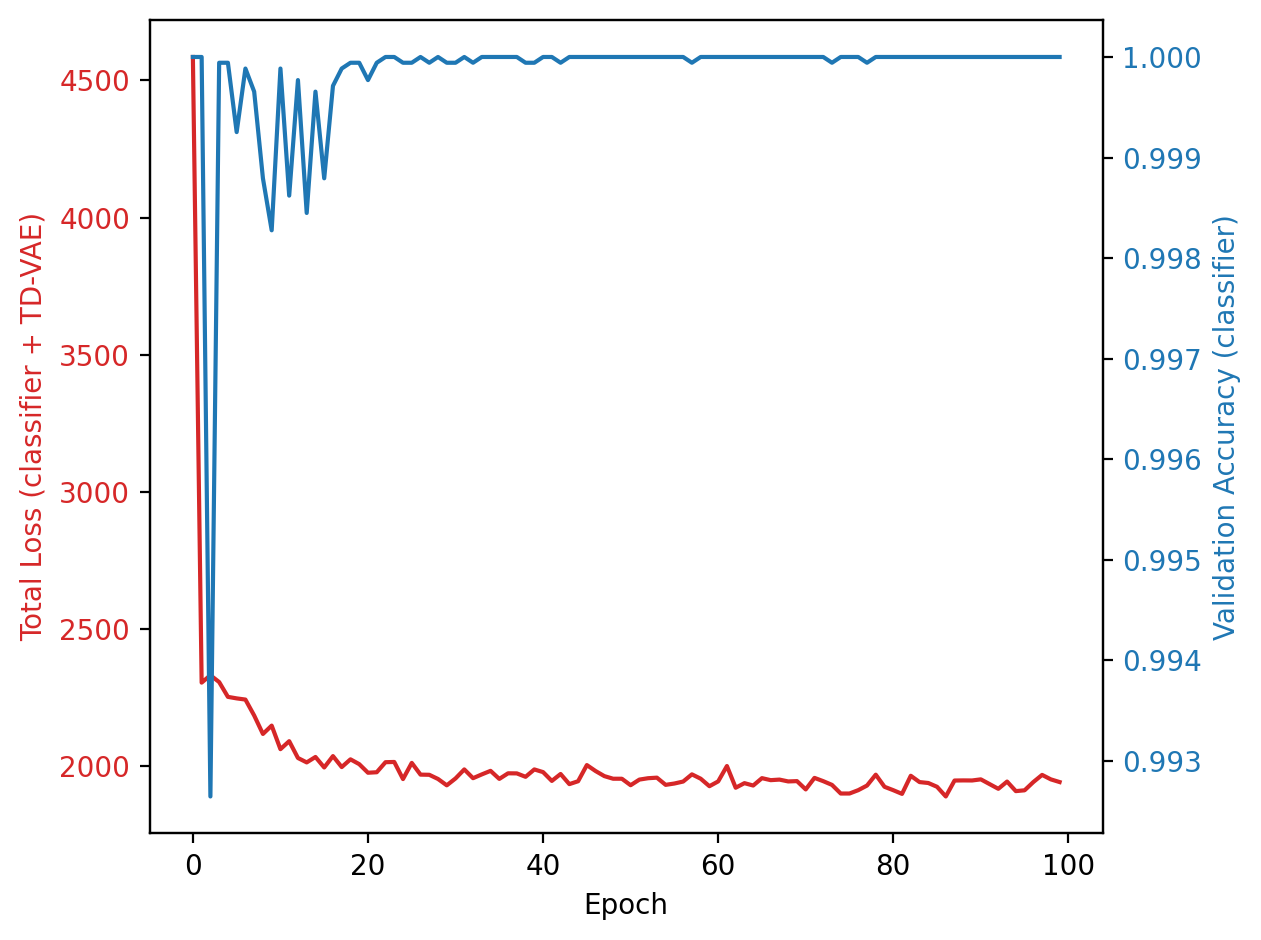

In [9]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss (classifier + TD-VAE)', color=color)
ax1.plot(log.index, log['tloss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy (classifier)', color=color)  # we already handled the x-label with ax1
ax2.plot(log.index, log['val_acc'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Continue

In [ ]:
del(data)
del(dataset)
del(loader)
del(train_dataset)
del(train_loader)
del(val_dataset)
del(val_loader)
del(model)

In [4]:
with open("./genesys_root_data.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
    
batch_size = 512
dataset = Root_Dataset(data['X_test'], data['y_test'])
loader = DataLoader(dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
train_dataset = Root_Dataset(data['X_train'], data['y_train'])
train_loader = DataLoader(train_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
val_dataset = Root_Dataset(data['X_val'], data['y_val'])
val_loader = DataLoader(val_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)

In [5]:
criterion = torch.nn.NLLLoss()
input_size = data['X_train'].shape[1]
## 10 cell types
output_size = 10
time_bins = 11
embedding_dim = 256
hidden_dim = 256
n_layers = 2
clip = 5
path = "./"
device = "cuda"
n_epochs = 100
train_on_gpu=True

In [6]:
model = ClassifierLSTM(input_size, output_size, embedding_dim, hidden_dim, n_layers).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
sch = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, threshold=0.05, verbose=True)

In [7]:
checkpoint = torch.load(path+"./genesys_model_trained_on_root_atlas_20240308.pth")
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [8]:
# Load previous logger
with open('log_genesys_model_trained_on_root_atlas_20240308.pkl', 'rb') as f:
        logger = pickle.load(f)

In [9]:
min(logger['tloss'])

1889.5226599651835

In [10]:
#logger = {'tloss': [], 'val_acc': []}
#best_val_acc = 0.99
best_loss = min(logger['tloss'])
for epoch in range(n_epochs):
    h = model.init_hidden(batch_size)
    c, s = 0, 0
    pBar = tqdm(train_loader)
    model.train()
    for sample in pBar:
        h = tuple([each.data for each in h])
        x = sample['x'].to(device)
        y = sample['y'].to(device)
        optimizer.zero_grad()
        t = np.random.choice(time_bins-1)
        p, h = model.predict(x, h, t)
        model.get_belief(x, h)
        tdvae_loss = model.calculate_loss(t)
        nll_loss = criterion(p, y)
        loss = tdvae_loss + nll_loss
        # print(loss)
        s = ((s*c)+(float(loss.item())*len(p)))/(c+len(p))
        c += len(p)
        pBar.set_description('Epoch {} Train: '.format(epoch) +str(round(float(s),4)))
        wl = np.random.choice(2)
        if wl == 0 :
            tdvae_loss.backward()
        else :
            nll_loss.backward()
        #loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    logger['tloss'].append(s)
    sch.step(s)

    val_h = model.init_hidden(batch_size)
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for sample in val_loader:
            val_h = tuple([each.data for each in val_h])
            x = sample['x'].to(device)
            y = sample['y'].to(device)
            #t = np.random.choice(11)
            t=1
            p, val_h = model.predict_proba(x, val_h, t)
            y_pred.append(p.cpu().detach().numpy())
            y_true.append(y.cpu().detach().numpy())
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)

    val_acc = (y_true == y_pred.argmax(axis=1)).mean()
    logger['val_acc'].append(val_acc)
    print("Validation Accuracy {:.4f}".format(val_acc))
    if (val_acc >= 0.99) & (s < best_loss):
        # print('Model improved')
        #best_val_acc = val_acc
        best_loss = s
        print(best_loss)
        torch.save(model.state_dict(), path+"/genesys_model_trained_on_root_atlas_20240308_continue.pth")
        val_stats = {'pred': y_pred, 'true': y_true}

with open('log_genesys_model_trained_on_root_atlas_20240308_continue.pkl', 'wb') as f:
    pickle.dump(logger, f)
#if cmat:
    # Plot validation confusion matrix
#    self.plot_cfmt(self.val_stats['pred'], self.val_stats['true'], 0.05, 'val_cfmt.pdf')

Epoch 0 Train: 1965.142: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.36it/s]


Validation Accuracy 0.9998


Epoch 1 Train: 1923.2891: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.38it/s]


Validation Accuracy 1.0000


Epoch 2 Train: 1975.1336: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.35it/s]


Validation Accuracy 0.9998


Epoch 3 Train: 1951.9006: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.35it/s]


Validation Accuracy 1.0000


Epoch 4 Train: 1952.4039: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.36it/s]


Validation Accuracy 0.9999


Epoch 5 Train: 1944.423: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.38it/s]


Validation Accuracy 0.9999


Epoch 6 Train: 1954.0683: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.38it/s]


Validation Accuracy 1.0000


Epoch 7 Train: 1935.6945: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 0.9999


Epoch 8 Train: 1923.1551: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 0.9999


Epoch 9 Train: 1925.5372: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.44it/s]


Validation Accuracy 1.0000


Epoch 10 Train: 1902.1359: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 11 Train: 1942.9931: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Epoch 00012: reducing learning rate of group 0 to 5.0000e-04.
Validation Accuracy 1.0000


Epoch 12 Train: 1935.3758: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 0.9999


Epoch 13 Train: 1946.9643: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 0.9999


Epoch 14 Train: 1959.3201: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 0.9999


Epoch 15 Train: 1951.5978: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 16 Train: 1940.9247: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 0.9999


Epoch 17 Train: 1953.9583: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 18 Train: 1922.3959: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 0.9999


Epoch 19 Train: 1969.2361: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 20 Train: 1910.2285: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 21 Train: 1929.6933: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 22 Train: 1983.0964: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Epoch 00023: reducing learning rate of group 0 to 2.5000e-04.
Validation Accuracy 0.9999


Epoch 23 Train: 1909.8747: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 24 Train: 1899.49: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 25 Train: 1924.6614: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 0.9999


Epoch 26 Train: 1934.4662: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 27 Train: 1937.0043: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 28 Train: 1934.6365: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 29 Train: 1938.6051: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 30 Train: 1952.0775: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 31 Train: 1926.6368: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 32 Train: 1938.0255: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 33 Train: 1920.0097: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Epoch 00034: reducing learning rate of group 0 to 1.2500e-04.
Validation Accuracy 1.0000


Epoch 34 Train: 1969.889: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 35 Train: 1943.5678: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 36 Train: 1885.5388: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000
1885.5387847458105


Epoch 37 Train: 1904.669: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 38 Train: 1907.981: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 39 Train: 1942.1397: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 0.9999


Epoch 40 Train: 1927.4854: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 41 Train: 1871.4945: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.42it/s]


Validation Accuracy 1.0000
1871.4944882600205


Epoch 42 Train: 1924.285: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 43 Train: 1942.1756: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 44 Train: 1935.8474: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.44it/s]


Epoch 00045: reducing learning rate of group 0 to 6.2500e-05.
Validation Accuracy 1.0000


Epoch 45 Train: 1929.8327: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.44it/s]


Validation Accuracy 1.0000


Epoch 46 Train: 1890.885: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.44it/s]


Validation Accuracy 1.0000


Epoch 47 Train: 1930.592: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 48 Train: 1908.0653: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 49 Train: 1950.4414: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 50 Train: 1899.7278: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 51 Train: 1908.4868: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 52 Train: 1913.8841: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 53 Train: 1967.6309: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 54 Train: 1913.1943: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 55 Train: 1951.5492: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Epoch 00056: reducing learning rate of group 0 to 3.1250e-05.
Validation Accuracy 1.0000


Epoch 56 Train: 1928.9739: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 57 Train: 1940.0053: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 58 Train: 1893.3084: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 59 Train: 1892.9904: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 60 Train: 1906.6801: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 61 Train: 1946.417: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 62 Train: 1960.1453: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 63 Train: 1908.2002: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 64 Train: 1931.1919: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 65 Train: 1896.7845: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 66 Train: 1940.368: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Epoch 00067: reducing learning rate of group 0 to 1.5625e-05.
Validation Accuracy 1.0000


Epoch 67 Train: 1895.9591: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 68 Train: 1929.9871: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 69 Train: 1929.7649: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 70 Train: 1881.5744: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 71 Train: 1936.4738: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 72 Train: 1936.4513: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 73 Train: 1936.988: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 74 Train: 1950.1514: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 75 Train: 1869.1488: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000
1869.148801057235


Epoch 76 Train: 1962.6722: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 77 Train: 1950.9887: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.42it/s]


Epoch 00078: reducing learning rate of group 0 to 7.8125e-06.
Validation Accuracy 1.0000


Epoch 78 Train: 1942.1144: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 79 Train: 1955.6979: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 80 Train: 1921.9385: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 81 Train: 1908.4276: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 0.9999


Epoch 82 Train: 1923.4648: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 83 Train: 1930.9573: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 84 Train: 1950.4175: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 85 Train: 1933.1818: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 86 Train: 1938.5789: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 87 Train: 1883.9764: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 88 Train: 1960.2441: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Epoch 00089: reducing learning rate of group 0 to 3.9063e-06.
Validation Accuracy 1.0000


Epoch 89 Train: 1933.4374: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 90 Train: 1929.3865: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.38it/s]


Validation Accuracy 1.0000


Epoch 91 Train: 1937.9231: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 92 Train: 1921.1994: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 93 Train: 1904.4664: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 94 Train: 1955.4957: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.32it/s]


Validation Accuracy 1.0000


Epoch 95 Train: 1920.1307: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.33it/s]


Validation Accuracy 1.0000


Epoch 96 Train: 1927.6381: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.33it/s]


Validation Accuracy 1.0000


Epoch 97 Train: 1908.6541: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.33it/s]


Validation Accuracy 1.0000


Epoch 98 Train: 1933.8164: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.33it/s]


Validation Accuracy 1.0000


Epoch 99 Train: 1943.2197: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 00100: reducing learning rate of group 0 to 1.9531e-06.
Validation Accuracy 1.0000


In [11]:
print(best_loss)

1869.148801057235


In [12]:
log = pd.DataFrame(logger)
log.to_csv("log_root_atlas_20240308_continue.csv")
log = pd.read_csv("log_root_atlas_20240308_continue.csv", index_col=0)

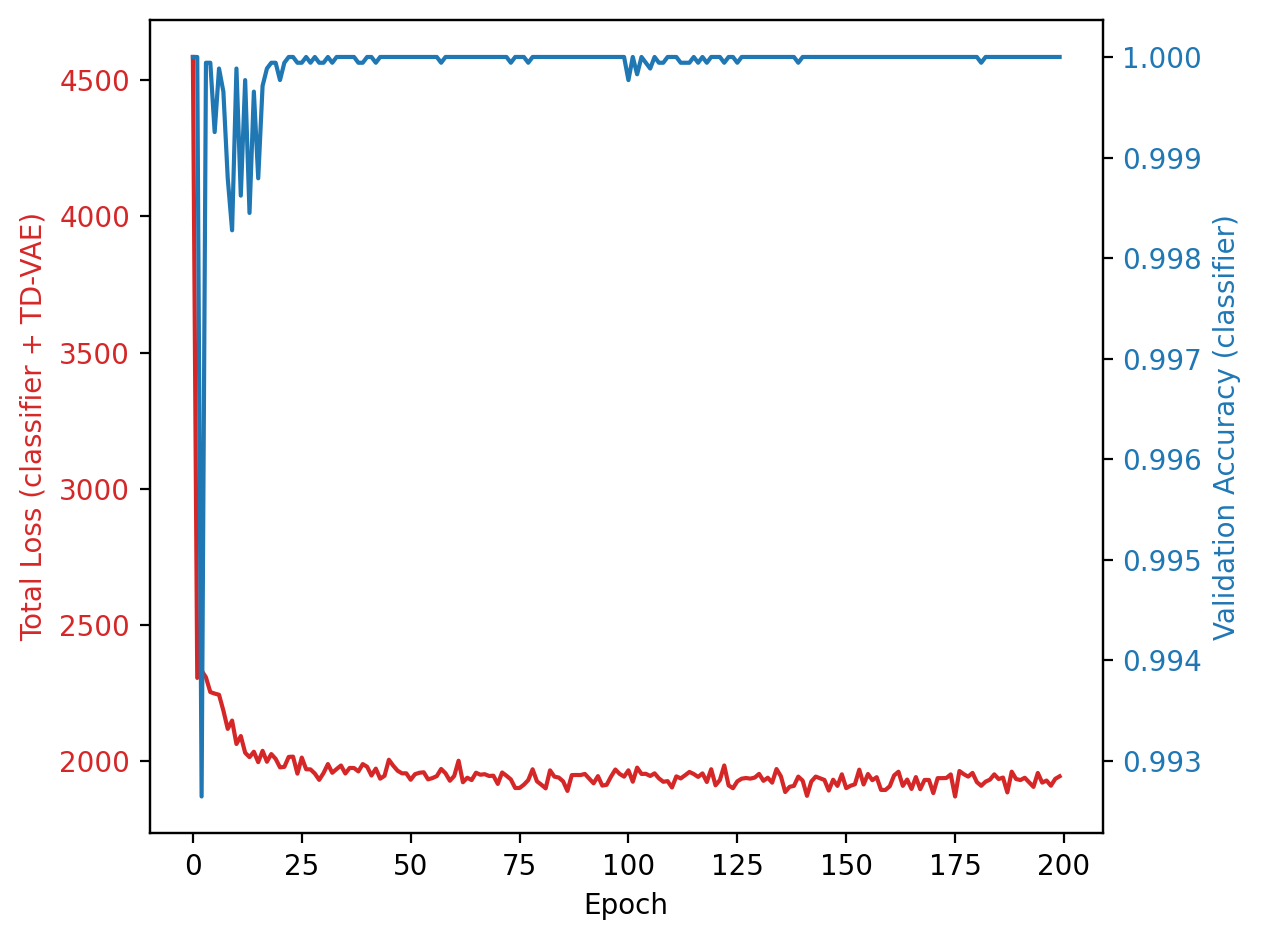

In [13]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss (classifier + TD-VAE)', color=color)
ax1.plot(log.index, log['tloss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy (classifier)', color=color)  # we already handled the x-label with ax1
ax2.plot(log.index, log['val_acc'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Continue

In [ ]:
del(data)
del(dataset)
del(loader)
del(train_dataset)
del(train_loader)
del(val_dataset)
del(val_loader)
del(model)

In [4]:
with open("./genesys_root_data.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
    
batch_size = 512
dataset = Root_Dataset(data['X_test'], data['y_test'])
loader = DataLoader(dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
train_dataset = Root_Dataset(data['X_train'], data['y_train'])
train_loader = DataLoader(train_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
val_dataset = Root_Dataset(data['X_val'], data['y_val'])
val_loader = DataLoader(val_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)

In [5]:
criterion = torch.nn.NLLLoss()
input_size = data['X_train'].shape[1]
## 10 cell types
output_size = 10
time_bins = 11
embedding_dim = 256
hidden_dim = 256
n_layers = 2
clip = 5
path = "./"
device = "cuda"
n_epochs = 100
train_on_gpu=True

In [6]:
model = ClassifierLSTM(input_size, output_size, embedding_dim, hidden_dim, n_layers).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
sch = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, threshold=0.05, verbose=True)

In [7]:
checkpoint = torch.load(path+"./genesys_model_trained_on_root_atlas_20240308_continue.pth")
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [8]:
# Load previous logger
with open('log_genesys_model_trained_on_root_atlas_20240308_continue.pkl', 'rb') as f:
        logger = pickle.load(f)

In [9]:
min(logger['tloss'])

1869.148801057235

In [10]:
#logger = {'tloss': [], 'val_acc': []}
#best_val_acc = 0.99
best_loss = min(logger['tloss'])
for epoch in range(n_epochs):
    h = model.init_hidden(batch_size)
    c, s = 0, 0
    pBar = tqdm(train_loader)
    model.train()
    for sample in pBar:
        h = tuple([each.data for each in h])
        x = sample['x'].to(device)
        y = sample['y'].to(device)
        optimizer.zero_grad()
        t = np.random.choice(time_bins-1)
        p, h = model.predict(x, h, t)
        model.get_belief(x, h)
        tdvae_loss = model.calculate_loss(t)
        nll_loss = criterion(p, y)
        loss = tdvae_loss + nll_loss
        # print(loss)
        s = ((s*c)+(float(loss.item())*len(p)))/(c+len(p))
        c += len(p)
        pBar.set_description('Epoch {} Train: '.format(epoch) +str(round(float(s),4)))
        wl = np.random.choice(2)
        if wl == 0 :
            tdvae_loss.backward()
        else :
            nll_loss.backward()
        #loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    logger['tloss'].append(s)
    sch.step(s)

    val_h = model.init_hidden(batch_size)
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for sample in val_loader:
            val_h = tuple([each.data for each in val_h])
            x = sample['x'].to(device)
            y = sample['y'].to(device)
            #t = np.random.choice(11)
            t=1
            p, val_h = model.predict_proba(x, val_h, t)
            y_pred.append(p.cpu().detach().numpy())
            y_true.append(y.cpu().detach().numpy())
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)

    val_acc = (y_true == y_pred.argmax(axis=1)).mean()
    logger['val_acc'].append(val_acc)
    print("Validation Accuracy {:.4f}".format(val_acc))
    if (val_acc >= 0.99) & (s < best_loss):
        # print('Model improved')
        #best_val_acc = val_acc
        best_loss = s
        print(best_loss)
        torch.save(model.state_dict(), path+"/genesys_model_trained_on_root_atlas_20240308_continue2.pth")
        val_stats = {'pred': y_pred, 'true': y_true}

with open('log_genesys_model_trained_on_root_atlas_20240308_continue2.pkl', 'wb') as f:
    pickle.dump(logger, f)
#if cmat:
    # Plot validation confusion matrix
#    self.plot_cfmt(self.val_stats['pred'], self.val_stats['true'], 0.05, 'val_cfmt.pdf')

Epoch 0 Train: 1972.3049: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 1 Train: 1932.2641: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 2 Train: 1914.9849: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 3 Train: 1931.6581: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 4 Train: 1931.7441: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 5 Train: 1925.8045: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 0.9999


Epoch 6 Train: 1910.9446: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 7 Train: 1978.0429: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 8 Train: 1907.5203: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 9 Train: 1976.5271: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 10 Train: 1942.1721: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.44it/s]


Validation Accuracy 1.0000


Epoch 11 Train: 1909.4109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Epoch 00012: reducing learning rate of group 0 to 5.0000e-04.
Validation Accuracy 1.0000


Epoch 12 Train: 1890.4723: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 13 Train: 1924.6639: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 0.9999


Epoch 14 Train: 1945.7058: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 15 Train: 1970.0154: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 16 Train: 1950.3609: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 17 Train: 1937.48: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 18 Train: 1938.316: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 19 Train: 1929.3391: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 20 Train: 1905.7305: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 21 Train: 1866.5039: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000
1866.503935440727


Epoch 22 Train: 1916.1228: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.44it/s]


Validation Accuracy 1.0000


Epoch 23 Train: 1916.3114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.45it/s]


Validation Accuracy 1.0000


Epoch 24 Train: 1925.0992: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.44it/s]


Validation Accuracy 1.0000


Epoch 25 Train: 1940.9617: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 26 Train: 1945.4923: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.45it/s]


Validation Accuracy 1.0000


Epoch 27 Train: 1938.9097: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.44it/s]


Validation Accuracy 1.0000


Epoch 28 Train: 1918.7891: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 29 Train: 1907.9207: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.44it/s]


Validation Accuracy 1.0000


Epoch 30 Train: 1923.1359: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.45it/s]


Validation Accuracy 1.0000


Epoch 31 Train: 1931.9986: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 32 Train: 1896.6216: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Epoch 00033: reducing learning rate of group 0 to 2.5000e-04.
Validation Accuracy 1.0000


Epoch 33 Train: 1936.7798: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 34 Train: 1937.9689: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 35 Train: 1922.9643: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 0.9999


Epoch 36 Train: 1914.8142: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 37 Train: 1947.5972: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 38 Train: 1910.9811: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.42it/s]


Validation Accuracy 0.9999


Epoch 39 Train: 1927.6404: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 40 Train: 1932.2459: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.44it/s]


Validation Accuracy 1.0000


Epoch 41 Train: 1915.2148: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 0.9999


Epoch 42 Train: 1933.7851: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 43 Train: 1917.2956: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Epoch 00044: reducing learning rate of group 0 to 1.2500e-04.
Validation Accuracy 1.0000


Epoch 44 Train: 1935.8455: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.42it/s]


Validation Accuracy 0.9999


Epoch 45 Train: 1882.1274: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 46 Train: 1903.3902: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 47 Train: 1919.9927: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.44it/s]


Validation Accuracy 0.9999


Epoch 48 Train: 1924.1677: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 49 Train: 1905.7633: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 50 Train: 1940.2232: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 51 Train: 1942.8292: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 52 Train: 1921.0223: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.44it/s]


Validation Accuracy 1.0000


Epoch 53 Train: 1875.7028: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 54 Train: 1890.0793: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.44it/s]


Epoch 00055: reducing learning rate of group 0 to 6.2500e-05.
Validation Accuracy 1.0000


Epoch 55 Train: 1912.012: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 56 Train: 1959.1414: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 57 Train: 1934.1934: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 58 Train: 1922.1015: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 59 Train: 1920.8722: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 60 Train: 1913.671: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.44it/s]


Validation Accuracy 1.0000


Epoch 61 Train: 1911.0904: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 62 Train: 1913.4524: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 63 Train: 1926.0632: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 64 Train: 1914.2363: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 65 Train: 1933.5246: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Epoch 00066: reducing learning rate of group 0 to 3.1250e-05.
Validation Accuracy 1.0000


Epoch 66 Train: 1954.9832: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 67 Train: 1905.9842: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 68 Train: 1961.0082: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 69 Train: 1905.5279: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 70 Train: 1909.8944: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 71 Train: 1888.4092: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 72 Train: 1967.0549: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 73 Train: 1961.7293: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 74 Train: 1910.3437: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 75 Train: 1917.1364: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 76 Train: 1925.6948: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Epoch 00077: reducing learning rate of group 0 to 1.5625e-05.
Validation Accuracy 1.0000


Epoch 77 Train: 1909.3026: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 78 Train: 1911.1255: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 79 Train: 1955.7309: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 80 Train: 1906.5905: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 81 Train: 1930.932: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 82 Train: 1949.1459: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 83 Train: 1917.3182: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 84 Train: 1960.4246: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 85 Train: 1895.0282: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 86 Train: 1936.7917: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 87 Train: 1957.4013: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Epoch 00088: reducing learning rate of group 0 to 7.8125e-06.
Validation Accuracy 1.0000


Epoch 88 Train: 1947.3722: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.44it/s]


Validation Accuracy 1.0000


Epoch 89 Train: 1886.1285: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.44it/s]


Validation Accuracy 1.0000


Epoch 90 Train: 1888.5881: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 91 Train: 1944.1304: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 92 Train: 1913.1218: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 93 Train: 1975.6043: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 94 Train: 1930.9658: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 95 Train: 1924.3062: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 96 Train: 1902.5048: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 97 Train: 1906.9909: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 98 Train: 1918.7914: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.44it/s]


Epoch 00099: reducing learning rate of group 0 to 3.9063e-06.
Validation Accuracy 1.0000


Epoch 99 Train: 1900.4851: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.44it/s]


Validation Accuracy 1.0000


In [11]:
print(best_loss)

1866.503935440727


In [12]:
log = pd.DataFrame(logger)
log.to_csv("log_root_atlas_20240308_continue2.csv")
log = pd.read_csv("log_root_atlas_20240308_continue2.csv", index_col=0)

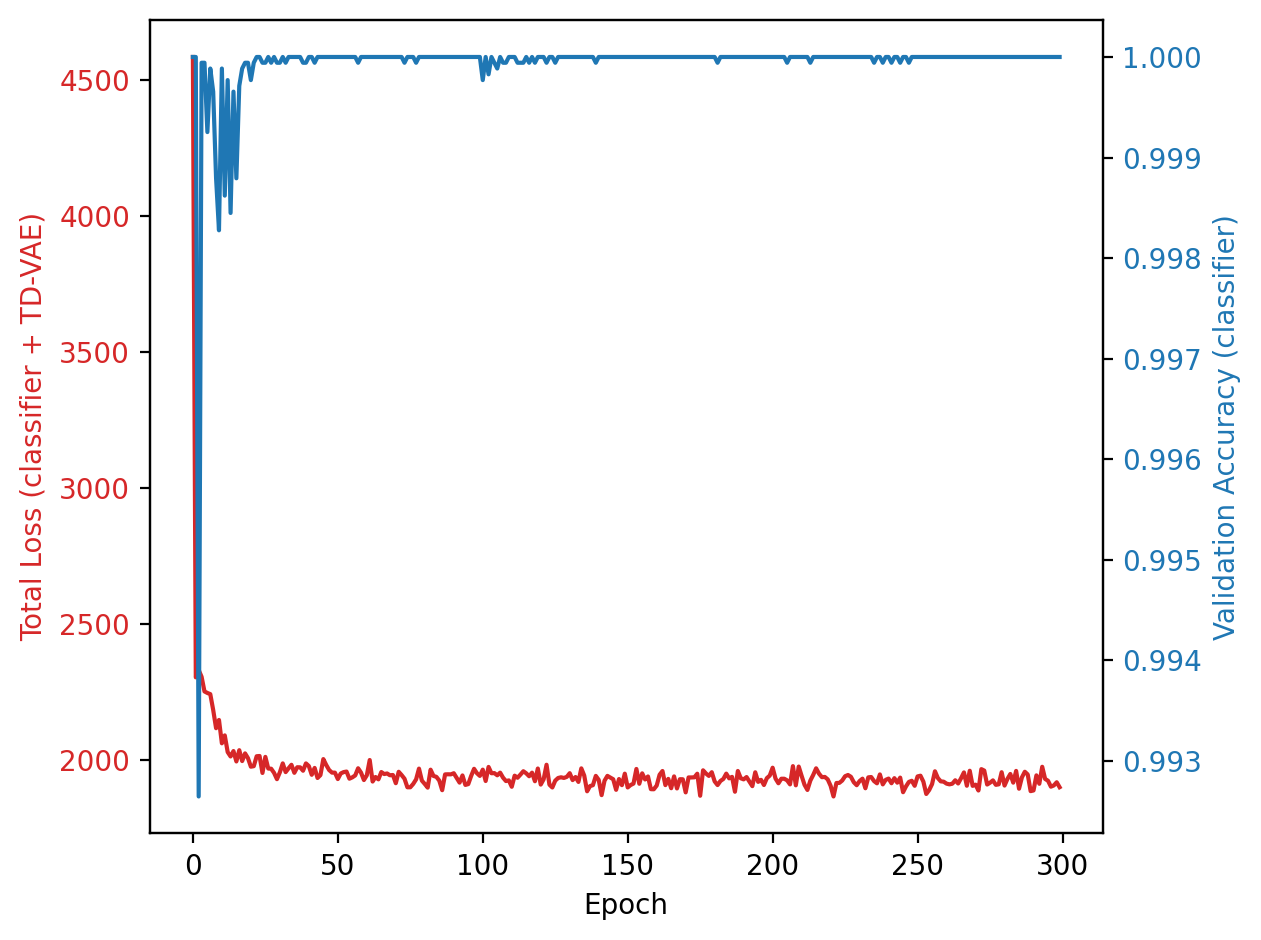

In [13]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss (classifier + TD-VAE)', color=color)
ax1.plot(log.index, log['tloss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy (classifier)', color=color)  # we already handled the x-label with ax1
ax2.plot(log.index, log['val_acc'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Continue

In [14]:
del(data)
del(dataset)
del(loader)
del(train_dataset)
del(train_loader)
del(val_dataset)
del(val_loader)
del(model)

In [4]:
with open("./genesys_root_data.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
    
batch_size = 512
dataset = Root_Dataset(data['X_test'], data['y_test'])
loader = DataLoader(dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
train_dataset = Root_Dataset(data['X_train'], data['y_train'])
train_loader = DataLoader(train_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
val_dataset = Root_Dataset(data['X_val'], data['y_val'])
val_loader = DataLoader(val_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)

In [5]:
criterion = torch.nn.NLLLoss()
input_size = data['X_train'].shape[1]
## 10 cell types
output_size = 10
time_bins = 11
embedding_dim = 256
hidden_dim = 256
n_layers = 2
clip = 5
path = "./"
device = "cuda"
n_epochs = 100
train_on_gpu=True

In [6]:
model = ClassifierLSTM(input_size, output_size, embedding_dim, hidden_dim, n_layers).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
sch = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, threshold=0.05, verbose=True)

In [7]:
checkpoint = torch.load(path+"./genesys_model_trained_on_root_atlas_20240308_continue2.pth")
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [8]:
# Load previous logger
with open('log_genesys_model_trained_on_root_atlas_20240308_continue2.pkl', 'rb') as f:
        logger = pickle.load(f)

In [9]:
min(logger['tloss'])

1866.503935440727

In [10]:
#logger = {'tloss': [], 'val_acc': []}
#best_val_acc = 0.99
best_loss = min(logger['tloss'])
for epoch in range(n_epochs):
    h = model.init_hidden(batch_size)
    c, s = 0, 0
    pBar = tqdm(train_loader)
    model.train()
    for sample in pBar:
        h = tuple([each.data for each in h])
        x = sample['x'].to(device)
        y = sample['y'].to(device)
        optimizer.zero_grad()
        t = np.random.choice(time_bins-1)
        p, h = model.predict(x, h, t)
        model.get_belief(x, h)
        tdvae_loss = model.calculate_loss(t)
        nll_loss = criterion(p, y)
        loss = tdvae_loss + nll_loss
        # print(loss)
        s = ((s*c)+(float(loss.item())*len(p)))/(c+len(p))
        c += len(p)
        pBar.set_description('Epoch {} Train: '.format(epoch) +str(round(float(s),4)))
        wl = np.random.choice(2)
        if wl == 0 :
            tdvae_loss.backward()
        else :
            nll_loss.backward()
        #loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    logger['tloss'].append(s)
    sch.step(s)

    val_h = model.init_hidden(batch_size)
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for sample in val_loader:
            val_h = tuple([each.data for each in val_h])
            x = sample['x'].to(device)
            y = sample['y'].to(device)
            #t = np.random.choice(11)
            t=1
            p, val_h = model.predict_proba(x, val_h, t)
            y_pred.append(p.cpu().detach().numpy())
            y_true.append(y.cpu().detach().numpy())
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)

    val_acc = (y_true == y_pred.argmax(axis=1)).mean()
    logger['val_acc'].append(val_acc)
    print("Validation Accuracy {:.4f}".format(val_acc))
    if (val_acc >= 0.99) & (s < best_loss):
        # print('Model improved')
        #best_val_acc = val_acc
        best_loss = s
        print(best_loss)
        torch.save(model.state_dict(), path+"/genesys_model_trained_on_root_atlas_20240308_continue3.pth")
        val_stats = {'pred': y_pred, 'true': y_true}

with open('log_genesys_model_trained_on_root_atlas_20240308_continue3.pkl', 'wb') as f:
    pickle.dump(logger, f)
#if cmat:
    # Plot validation confusion matrix
#    self.plot_cfmt(self.val_stats['pred'], self.val_stats['true'], 0.05, 'val_cfmt.pdf')

Epoch 0 Train: 1962.4052: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 1 Train: 1969.5968: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 2 Train: 1916.6631: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.37it/s]


Validation Accuracy 1.0000


Epoch 3 Train: 1944.4801: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.38it/s]


Validation Accuracy 1.0000


Epoch 4 Train: 1940.1126: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 5 Train: 1956.9193: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 6 Train: 1938.7628: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 0.9999


Epoch 7 Train: 1957.7142: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 8 Train: 1939.5565: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 0.9999


Epoch 9 Train: 1951.5935: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 10 Train: 1933.286: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 11 Train: 1924.99: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Epoch 00012: reducing learning rate of group 0 to 5.0000e-04.
Validation Accuracy 1.0000


Epoch 12 Train: 1949.5603: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 13 Train: 1966.3446: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 14 Train: 1947.1756: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 15 Train: 1938.9085: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 16 Train: 1939.1797: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 17 Train: 1876.5133: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 18 Train: 1941.6854: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 19 Train: 1912.2787: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 20 Train: 1903.2642: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 21 Train: 1973.9731: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 22 Train: 1924.4916: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Epoch 00023: reducing learning rate of group 0 to 2.5000e-04.
Validation Accuracy 1.0000


Epoch 23 Train: 1944.9987: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 24 Train: 1947.2627: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 25 Train: 1855.8047: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.44it/s]


Validation Accuracy 1.0000
1855.8046910382698


Epoch 26 Train: 1922.7636: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 27 Train: 1893.2873: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 28 Train: 1911.9142: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 29 Train: 1953.8502: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 30 Train: 1907.6953: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 31 Train: 1895.6602: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 32 Train: 1926.8595: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 33 Train: 1873.5768: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 34 Train: 1938.1463: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 35 Train: 1901.3233: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.42it/s]


Validation Accuracy 0.9999


Epoch 36 Train: 1933.314: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Epoch 00037: reducing learning rate of group 0 to 1.2500e-04.
Validation Accuracy 1.0000


Epoch 37 Train: 1932.2915: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 38 Train: 1933.7915: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.43it/s]


Validation Accuracy 1.0000


Epoch 39 Train: 1904.4776: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 40 Train: 1910.5482: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 41 Train: 1938.0242: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 0.9999


Epoch 42 Train: 1918.4121: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.37it/s]


Validation Accuracy 1.0000


Epoch 43 Train: 1958.503: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.37it/s]


Validation Accuracy 1.0000


Epoch 44 Train: 1896.9683: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.36it/s]


Validation Accuracy 1.0000


Epoch 45 Train: 1898.2073: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.36it/s]


Validation Accuracy 1.0000


Epoch 46 Train: 1845.5375: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.37it/s]


Validation Accuracy 1.0000
1845.5375065457993


Epoch 47 Train: 1916.909: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Epoch 00048: reducing learning rate of group 0 to 6.2500e-05.
Validation Accuracy 1.0000


Epoch 48 Train: 1894.2373: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 49 Train: 1906.8883: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.38it/s]


Validation Accuracy 1.0000


Epoch 50 Train: 1917.8349: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.38it/s]


Validation Accuracy 1.0000


Epoch 51 Train: 1944.5202: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.37it/s]


Validation Accuracy 1.0000


Epoch 52 Train: 1900.131: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.38it/s]


Validation Accuracy 1.0000


Epoch 53 Train: 1909.7693: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 54 Train: 1945.7181: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 55 Train: 1906.0796: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 56 Train: 1912.7667: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 57 Train: 1937.1147: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 58 Train: 1922.3141: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Epoch 00059: reducing learning rate of group 0 to 3.1250e-05.
Validation Accuracy 1.0000


Epoch 59 Train: 1897.4088: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 60 Train: 1935.673: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 61 Train: 1864.7432: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 62 Train: 1893.7281: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 63 Train: 1909.6228: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 64 Train: 1887.9945: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 65 Train: 1934.6494: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 66 Train: 1913.8582: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 67 Train: 1897.999: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 68 Train: 1909.2209: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 69 Train: 1900.8268: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Epoch 00070: reducing learning rate of group 0 to 1.5625e-05.
Validation Accuracy 1.0000


Epoch 70 Train: 1934.2446: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 71 Train: 1885.485: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 72 Train: 1933.6221: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 73 Train: 1922.5137: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 74 Train: 1930.4571: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 75 Train: 1929.2773: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 76 Train: 1927.1387: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 77 Train: 1900.1145: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 78 Train: 1892.723: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 79 Train: 1908.7452: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.38it/s]


Validation Accuracy 1.0000


Epoch 80 Train: 1897.2208: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Epoch 00081: reducing learning rate of group 0 to 7.8125e-06.
Validation Accuracy 1.0000


Epoch 81 Train: 1917.2649: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 82 Train: 1901.6983: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 83 Train: 1930.376: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 84 Train: 1871.9054: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 85 Train: 1891.208: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 86 Train: 1912.0332: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 87 Train: 1908.3518: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 88 Train: 1970.9741: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 89 Train: 1882.1762: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 90 Train: 1939.9399: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 91 Train: 1899.3112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Epoch 00092: reducing learning rate of group 0 to 3.9063e-06.
Validation Accuracy 1.0000


Epoch 92 Train: 1897.6836: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 93 Train: 1878.6324: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 94 Train: 1925.3515: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 95 Train: 1907.9992: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 96 Train: 1989.5456: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 97 Train: 1867.3264: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 98 Train: 1967.9619: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 99 Train: 1917.8973: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.37it/s]


Validation Accuracy 1.0000


In [11]:
print(best_loss)

1845.5375065457993


In [12]:
log = pd.DataFrame(logger)
log.to_csv("log_root_atlas_20240308_continue3.csv")
log = pd.read_csv("log_root_atlas_20240308_continue3.csv", index_col=0)

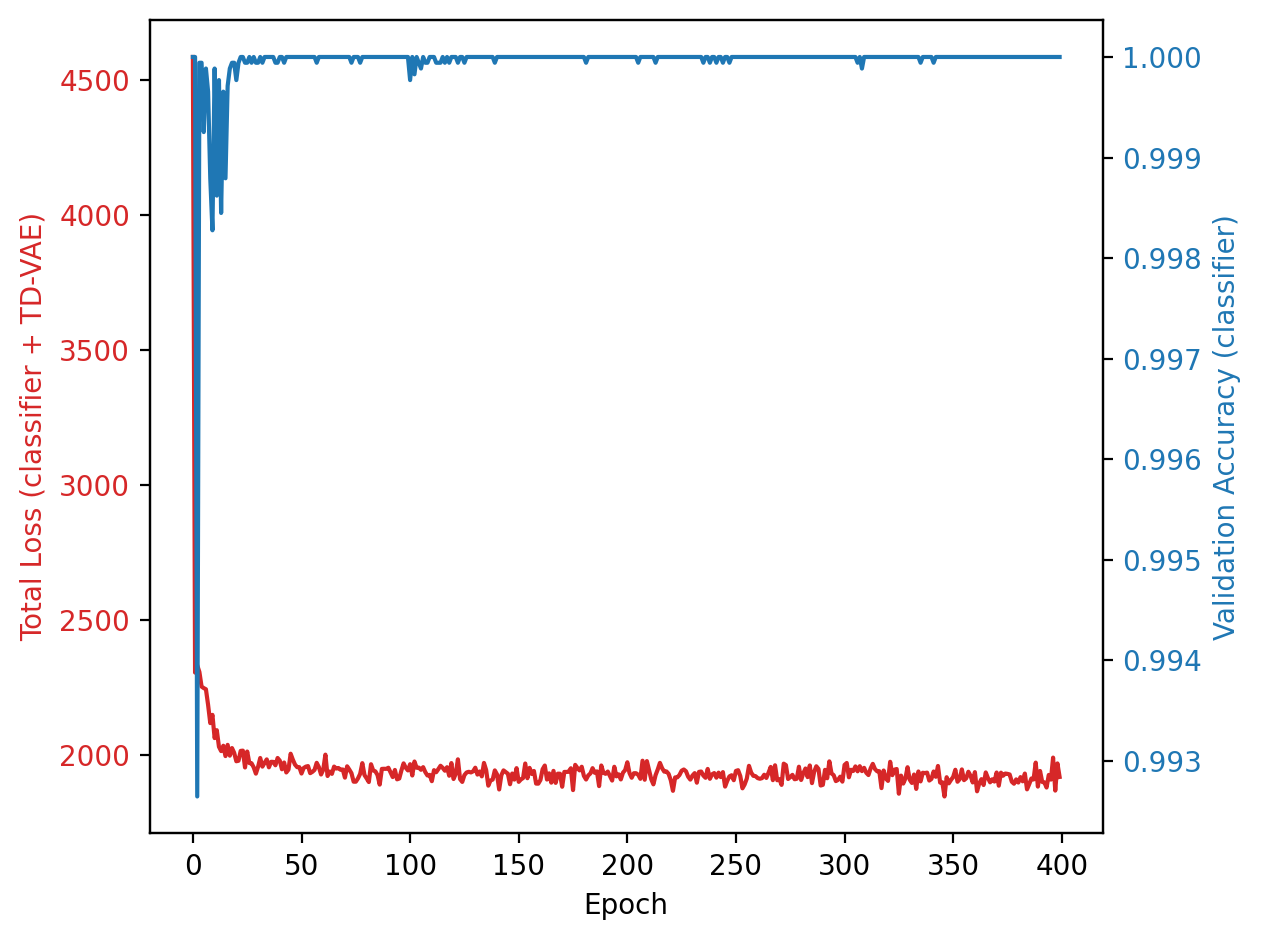

In [13]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss (classifier + TD-VAE)', color=color)
ax1.plot(log.index, log['tloss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy (classifier)', color=color)  # we already handled the x-label with ax1
ax2.plot(log.index, log['val_acc'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Continue

In [14]:
del(data)
del(dataset)
del(loader)
del(train_dataset)
del(train_loader)
del(val_dataset)
del(val_loader)
del(model)

In [15]:
with open("./genesys_root_data.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
    
batch_size = 512
dataset = Root_Dataset(data['X_test'], data['y_test'])
loader = DataLoader(dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
train_dataset = Root_Dataset(data['X_train'], data['y_train'])
train_loader = DataLoader(train_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
val_dataset = Root_Dataset(data['X_val'], data['y_val'])
val_loader = DataLoader(val_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)

In [16]:
criterion = torch.nn.NLLLoss()
input_size = data['X_train'].shape[1]
## 10 cell types
output_size = 10
time_bins = 11
embedding_dim = 256
hidden_dim = 256
n_layers = 2
clip = 5
path = "./"
device = "cuda"
n_epochs = 100
train_on_gpu=True

In [17]:
model = ClassifierLSTM(input_size, output_size, embedding_dim, hidden_dim, n_layers).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
sch = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, threshold=0.05, verbose=True)

In [18]:
checkpoint = torch.load(path+"./genesys_model_trained_on_root_atlas_20240308_continue3.pth")
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [19]:
# Load previous logger
with open('log_genesys_model_trained_on_root_atlas_20240308_continue3.pkl', 'rb') as f:
        logger = pickle.load(f)

In [20]:
min(logger['tloss'])

1845.5375065457993

In [21]:
#logger = {'tloss': [], 'val_acc': []}
#best_val_acc = 0.99
best_loss = min(logger['tloss'])
for epoch in range(n_epochs):
    h = model.init_hidden(batch_size)
    c, s = 0, 0
    pBar = tqdm(train_loader)
    model.train()
    for sample in pBar:
        h = tuple([each.data for each in h])
        x = sample['x'].to(device)
        y = sample['y'].to(device)
        optimizer.zero_grad()
        t = np.random.choice(time_bins-1)
        p, h = model.predict(x, h, t)
        model.get_belief(x, h)
        tdvae_loss = model.calculate_loss(t)
        nll_loss = criterion(p, y)
        loss = tdvae_loss + nll_loss
        # print(loss)
        s = ((s*c)+(float(loss.item())*len(p)))/(c+len(p))
        c += len(p)
        pBar.set_description('Epoch {} Train: '.format(epoch) +str(round(float(s),4)))
        wl = np.random.choice(2)
        if wl == 0 :
            tdvae_loss.backward()
        else :
            nll_loss.backward()
        #loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    logger['tloss'].append(s)
    sch.step(s)

    val_h = model.init_hidden(batch_size)
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for sample in val_loader:
            val_h = tuple([each.data for each in val_h])
            x = sample['x'].to(device)
            y = sample['y'].to(device)
            #t = np.random.choice(11)
            t=1
            p, val_h = model.predict_proba(x, val_h, t)
            y_pred.append(p.cpu().detach().numpy())
            y_true.append(y.cpu().detach().numpy())
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)

    val_acc = (y_true == y_pred.argmax(axis=1)).mean()
    logger['val_acc'].append(val_acc)
    print("Validation Accuracy {:.4f}".format(val_acc))
    if (val_acc >= 0.99) & (s < best_loss):
        # print('Model improved')
        #best_val_acc = val_acc
        best_loss = s
        print(best_loss)
        torch.save(model.state_dict(), path+"/genesys_model_trained_on_root_atlas_20240308_continue4.pth")
        val_stats = {'pred': y_pred, 'true': y_true}

with open('log_genesys_model_trained_on_root_atlas_20240308_continue4.pkl', 'wb') as f:
    pickle.dump(logger, f)
#if cmat:
    # Plot validation confusion matrix
#    self.plot_cfmt(self.val_stats['pred'], self.val_stats['true'], 0.05, 'val_cfmt.pdf')

Epoch 0 Train: 1889.5336: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.32it/s]


Validation Accuracy 1.0000


Epoch 1 Train: 1931.6772: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.38it/s]


Validation Accuracy 1.0000


Epoch 2 Train: 1941.1061: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 3 Train: 1944.0133: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 4 Train: 1940.7455: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 5 Train: 1914.5823: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 6 Train: 1919.7471: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 7 Train: 1923.2012: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 8 Train: 1946.9767: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 9 Train: 1931.8919: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 0.9999


Epoch 10 Train: 1945.588: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 0.9999


Epoch 11 Train: 1915.652: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Epoch 00012: reducing learning rate of group 0 to 5.0000e-04.
Validation Accuracy 1.0000


Epoch 12 Train: 1903.9647: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 13 Train: 1913.4728: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 14 Train: 1923.974: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 15 Train: 1902.5554: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 16 Train: 1893.5876: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.38it/s]


Validation Accuracy 1.0000


Epoch 17 Train: 1934.4857: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 18 Train: 1918.025: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 19 Train: 1907.5591: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 20 Train: 1878.3297: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 21 Train: 1929.0403: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 22 Train: 1882.1669: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Epoch 00023: reducing learning rate of group 0 to 2.5000e-04.
Validation Accuracy 1.0000


Epoch 23 Train: 1916.5867: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 24 Train: 1877.9866: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 25 Train: 1932.1803: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 26 Train: 1911.1617: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 27 Train: 1915.4058: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 28 Train: 1893.154: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 29 Train: 1920.5076: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 30 Train: 1960.0674: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 31 Train: 1914.2785: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 32 Train: 1901.1868: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 33 Train: 1921.8573: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Epoch 00034: reducing learning rate of group 0 to 1.2500e-04.
Validation Accuracy 1.0000


Epoch 34 Train: 1891.8359: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 35 Train: 1898.76: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 36 Train: 1909.8436: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 37 Train: 1890.9337: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 38 Train: 1954.1406: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 39 Train: 1907.3973: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 40 Train: 1878.0584: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 41 Train: 1848.56: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 42 Train: 1892.064: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 43 Train: 1941.0588: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 44 Train: 1910.9158: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Epoch 00045: reducing learning rate of group 0 to 6.2500e-05.
Validation Accuracy 1.0000


Epoch 45 Train: 1837.4151: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000
1837.4151062896285


Epoch 46 Train: 1916.3302: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 47 Train: 1911.0188: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 48 Train: 1914.8051: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 49 Train: 1914.5489: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 50 Train: 1920.4721: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 51 Train: 1925.1042: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 52 Train: 1951.4624: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 53 Train: 1896.8937: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 54 Train: 1931.3138: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.38it/s]


Validation Accuracy 1.0000


Epoch 55 Train: 1901.7333: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Epoch 00056: reducing learning rate of group 0 to 3.1250e-05.
Validation Accuracy 1.0000


Epoch 56 Train: 1949.6605: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 57 Train: 1902.5791: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 58 Train: 1886.7122: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 59 Train: 1916.779: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 60 Train: 1912.4597: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 61 Train: 1935.4658: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 62 Train: 1911.4247: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 63 Train: 1947.6354: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 64 Train: 1885.3898: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 65 Train: 1899.3397: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 66 Train: 1915.7135: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Epoch 00067: reducing learning rate of group 0 to 1.5625e-05.
Validation Accuracy 1.0000


Epoch 67 Train: 1872.634: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 68 Train: 1929.0087: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 69 Train: 1906.7505: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 70 Train: 1923.7993: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 71 Train: 1883.8776: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 72 Train: 1884.8512: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 73 Train: 1955.7814: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 74 Train: 1935.5382: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 75 Train: 1897.8208: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 76 Train: 1878.9255: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 77 Train: 1914.3397: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Epoch 00078: reducing learning rate of group 0 to 7.8125e-06.
Validation Accuracy 1.0000


Epoch 78 Train: 1929.4693: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 79 Train: 1908.6476: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 80 Train: 1901.9357: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 81 Train: 1904.3458: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 82 Train: 1914.3661: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 83 Train: 1907.7752: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 84 Train: 1889.1589: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 85 Train: 1911.7258: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 86 Train: 1898.2254: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 87 Train: 1885.2636: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 88 Train: 1924.4608: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Epoch 00089: reducing learning rate of group 0 to 3.9063e-06.
Validation Accuracy 1.0000


Epoch 89 Train: 1933.2655: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 90 Train: 1889.9557: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 91 Train: 1898.0761: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 92 Train: 1912.6565: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 93 Train: 1946.949: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 94 Train: 1894.7928: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 95 Train: 1914.0302: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.38it/s]


Validation Accuracy 1.0000


Epoch 96 Train: 1923.7326: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.38it/s]


Validation Accuracy 1.0000


Epoch 97 Train: 1915.31: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 98 Train: 1882.7447: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 99 Train: 1888.8635: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Epoch 00100: reducing learning rate of group 0 to 1.9531e-06.
Validation Accuracy 1.0000


In [22]:
print(best_loss)

1837.4151062896285


In [23]:
log = pd.DataFrame(logger)
log.to_csv("log_root_atlas_20240308_continue4.csv")
log = pd.read_csv("log_root_atlas_20240308_continue4.csv", index_col=0)

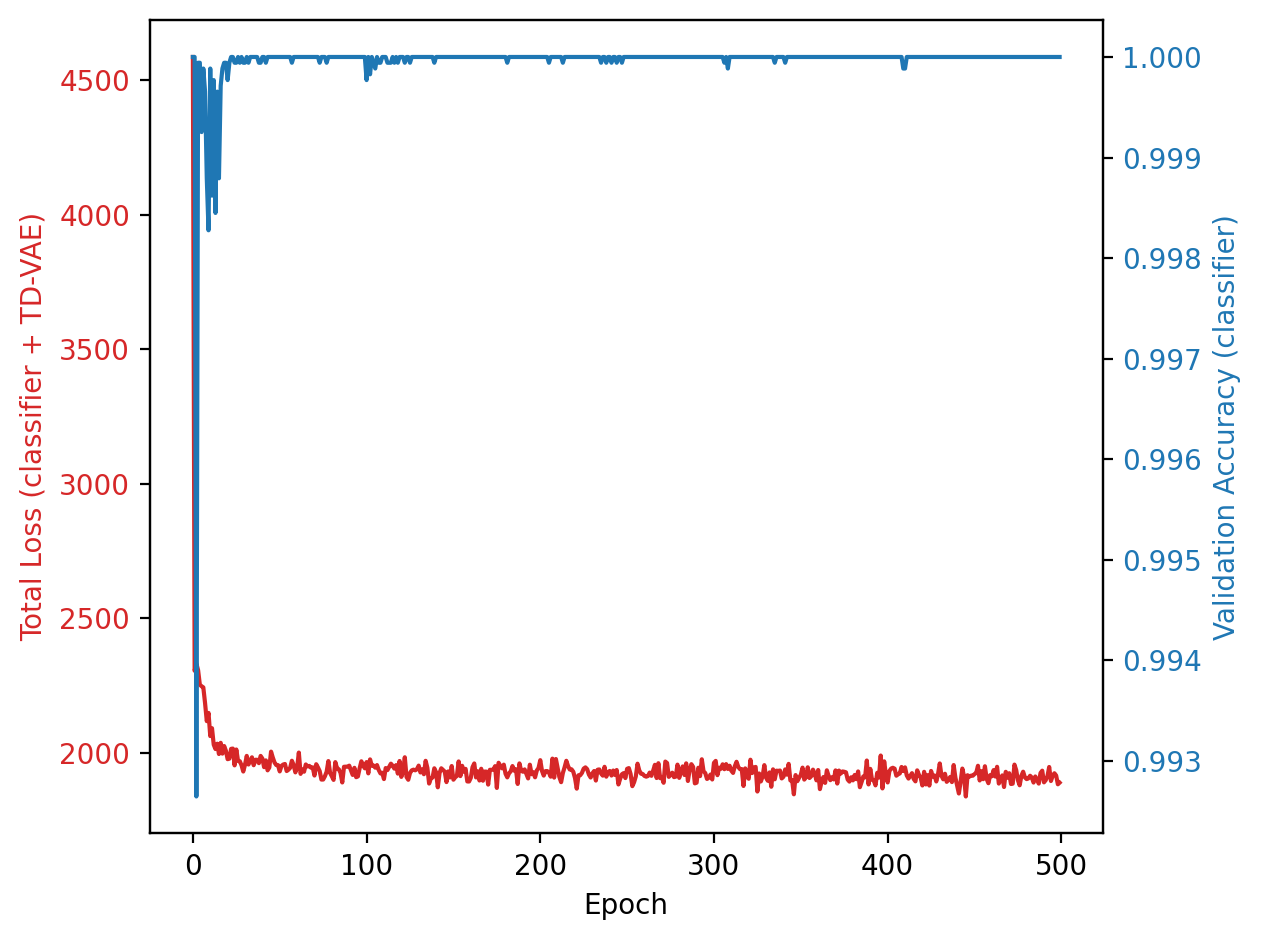

In [24]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss (classifier + TD-VAE)', color=color)
ax1.plot(log.index, log['tloss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy (classifier)', color=color)  # we already handled the x-label with ax1
ax2.plot(log.index, log['val_acc'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Continue

In [25]:
del(data)
del(dataset)
del(loader)
del(train_dataset)
del(train_loader)
del(val_dataset)
del(val_loader)
del(model)

In [26]:
with open("./genesys_root_data.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
    
batch_size = 512
dataset = Root_Dataset(data['X_test'], data['y_test'])
loader = DataLoader(dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
train_dataset = Root_Dataset(data['X_train'], data['y_train'])
train_loader = DataLoader(train_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
val_dataset = Root_Dataset(data['X_val'], data['y_val'])
val_loader = DataLoader(val_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)

In [27]:
criterion = torch.nn.NLLLoss()
input_size = data['X_train'].shape[1]
## 10 cell types
output_size = 10
time_bins = 11
embedding_dim = 256
hidden_dim = 256
n_layers = 2
clip = 5
path = "./"
device = "cuda"
n_epochs = 100
train_on_gpu=True

In [28]:
model = ClassifierLSTM(input_size, output_size, embedding_dim, hidden_dim, n_layers).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
sch = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, threshold=0.05, verbose=True)

In [29]:
checkpoint = torch.load(path+"./genesys_model_trained_on_root_atlas_20240308_continue4.pth")
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [30]:
# Load previous logger
with open('log_genesys_model_trained_on_root_atlas_20240308_continue4.pkl', 'rb') as f:
        logger = pickle.load(f)

In [31]:
min(logger['tloss'])

1837.4151062896285

In [32]:
#logger = {'tloss': [], 'val_acc': []}
#best_val_acc = 0.99
best_loss = min(logger['tloss'])
for epoch in range(n_epochs):
    h = model.init_hidden(batch_size)
    c, s = 0, 0
    pBar = tqdm(train_loader)
    model.train()
    for sample in pBar:
        h = tuple([each.data for each in h])
        x = sample['x'].to(device)
        y = sample['y'].to(device)
        optimizer.zero_grad()
        t = np.random.choice(time_bins-1)
        p, h = model.predict(x, h, t)
        model.get_belief(x, h)
        tdvae_loss = model.calculate_loss(t)
        nll_loss = criterion(p, y)
        loss = tdvae_loss + nll_loss
        # print(loss)
        s = ((s*c)+(float(loss.item())*len(p)))/(c+len(p))
        c += len(p)
        pBar.set_description('Epoch {} Train: '.format(epoch) +str(round(float(s),4)))
        wl = np.random.choice(2)
        if wl == 0 :
            tdvae_loss.backward()
        else :
            nll_loss.backward()
        #loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    logger['tloss'].append(s)
    sch.step(s)

    val_h = model.init_hidden(batch_size)
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for sample in val_loader:
            val_h = tuple([each.data for each in val_h])
            x = sample['x'].to(device)
            y = sample['y'].to(device)
            #t = np.random.choice(11)
            t=1
            p, val_h = model.predict_proba(x, val_h, t)
            y_pred.append(p.cpu().detach().numpy())
            y_true.append(y.cpu().detach().numpy())
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)

    val_acc = (y_true == y_pred.argmax(axis=1)).mean()
    logger['val_acc'].append(val_acc)
    print("Validation Accuracy {:.4f}".format(val_acc))
    if (val_acc >= 0.99) & (s < best_loss):
        # print('Model improved')
        #best_val_acc = val_acc
        best_loss = s
        print(best_loss)
        torch.save(model.state_dict(), path+"/genesys_model_trained_on_root_atlas_20240308_continue5.pth")
        val_stats = {'pred': y_pred, 'true': y_true}

with open('log_genesys_model_trained_on_root_atlas_20240308_continue5.pkl', 'wb') as f:
    pickle.dump(logger, f)
#if cmat:
    # Plot validation confusion matrix
#    self.plot_cfmt(self.val_stats['pred'], self.val_stats['true'], 0.05, 'val_cfmt.pdf')

Epoch 0 Train: 1924.4119: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.35it/s]


Validation Accuracy 1.0000


Epoch 1 Train: 1975.4763: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.38it/s]


Validation Accuracy 1.0000


Epoch 2 Train: 1939.9329: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.38it/s]


Validation Accuracy 1.0000


Epoch 3 Train: 1925.6426: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.38it/s]


Validation Accuracy 1.0000


Epoch 4 Train: 1884.8534: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.37it/s]


Validation Accuracy 1.0000


Epoch 5 Train: 1898.7534: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.38it/s]


Validation Accuracy 1.0000


Epoch 6 Train: 1944.4514: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.37it/s]


Validation Accuracy 1.0000


Epoch 7 Train: 1920.5036: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.38it/s]


Validation Accuracy 1.0000


Epoch 8 Train: 1910.8447: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.36it/s]


Validation Accuracy 1.0000


Epoch 9 Train: 1934.6054: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 10 Train: 1904.5589: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 11 Train: 1896.1419: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Epoch 00012: reducing learning rate of group 0 to 5.0000e-04.
Validation Accuracy 1.0000


Epoch 12 Train: 1957.2044: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.38it/s]


Validation Accuracy 1.0000


Epoch 13 Train: 1924.8812: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 14 Train: 1925.1633: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.38it/s]


Validation Accuracy 1.0000


Epoch 15 Train: 1923.2556: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.38it/s]


Validation Accuracy 1.0000


Epoch 16 Train: 1909.5035: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.38it/s]


Validation Accuracy 1.0000


Epoch 17 Train: 1884.7965: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 18 Train: 1894.4984: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 19 Train: 1911.6003: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 20 Train: 1932.3632: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 21 Train: 1931.6302: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 0.9999


Epoch 22 Train: 1941.3235: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Epoch 00023: reducing learning rate of group 0 to 2.5000e-04.
Validation Accuracy 0.9999


Epoch 23 Train: 1907.0868: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.38it/s]


Validation Accuracy 1.0000


Epoch 24 Train: 1922.3412: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.38it/s]


Validation Accuracy 0.9999


Epoch 25 Train: 1921.3785: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.38it/s]


Validation Accuracy 1.0000


Epoch 26 Train: 1901.1463: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 27 Train: 1919.6367: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 28 Train: 1904.6479: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 29 Train: 1909.8009: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 30 Train: 1889.0697: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 31 Train: 1916.0121: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 32 Train: 1900.546: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.38it/s]


Validation Accuracy 1.0000


Epoch 33 Train: 1918.5313: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.38it/s]


Epoch 00034: reducing learning rate of group 0 to 1.2500e-04.
Validation Accuracy 1.0000


Epoch 34 Train: 1926.0746: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.38it/s]


Validation Accuracy 1.0000


Epoch 35 Train: 1885.8011: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.38it/s]


Validation Accuracy 1.0000


Epoch 36 Train: 1926.749: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 37 Train: 1921.7806: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 38 Train: 1898.9303: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 39 Train: 1901.9422: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 40 Train: 1851.682: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 41 Train: 1913.7225: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 42 Train: 1896.8654: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 43 Train: 1883.516: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 44 Train: 1905.0239: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Epoch 00045: reducing learning rate of group 0 to 6.2500e-05.
Validation Accuracy 1.0000


Epoch 45 Train: 1882.1534: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 46 Train: 1922.6879: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 47 Train: 1927.3378: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 48 Train: 1901.7198: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 49 Train: 1920.9107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 50 Train: 1921.042: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 51 Train: 1959.8331: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 52 Train: 1882.5839: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 53 Train: 1918.6334: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 54 Train: 1854.5547: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 55 Train: 1944.942: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Epoch 00056: reducing learning rate of group 0 to 3.1250e-05.
Validation Accuracy 1.0000


Epoch 56 Train: 1916.6252: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 57 Train: 1952.6567: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 0.9999


Epoch 58 Train: 1889.3457: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 59 Train: 1955.4365: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 60 Train: 1943.1258: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 61 Train: 1917.7368: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 62 Train: 1937.8493: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:58<00:00,  2.38it/s]


Validation Accuracy 1.0000


Epoch 63 Train: 1901.1807: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 64 Train: 1934.8247: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 65 Train: 1896.0003: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 66 Train: 1909.3459: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Epoch 00067: reducing learning rate of group 0 to 1.5625e-05.
Validation Accuracy 0.9999


Epoch 67 Train: 1903.9752: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 68 Train: 1940.1172: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 69 Train: 1953.1793: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 70 Train: 1914.4623: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 0.9999


Epoch 71 Train: 1922.9795: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 72 Train: 1907.0127: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 73 Train: 1898.5672: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 74 Train: 1865.8873: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 75 Train: 1863.7115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 76 Train: 1953.0863: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Validation Accuracy 1.0000


Epoch 77 Train: 1926.1215: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Epoch 00078: reducing learning rate of group 0 to 7.8125e-06.
Validation Accuracy 1.0000


Epoch 78 Train: 1907.0897: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 0.9999


Epoch 79 Train: 1909.3284: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 80 Train: 1914.3935: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 0.9999


Epoch 81 Train: 1935.2666: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 82 Train: 1905.5647: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.38it/s]


Validation Accuracy 1.0000


Epoch 83 Train: 1909.2413: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 84 Train: 1884.8837: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 0.9999


Epoch 85 Train: 1889.4465: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 86 Train: 1912.6658: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 87 Train: 1920.0695: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 88 Train: 1862.658: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.42it/s]


Epoch 00089: reducing learning rate of group 0 to 3.9063e-06.
Validation Accuracy 1.0000


Epoch 89 Train: 1914.2494: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Validation Accuracy 1.0000


Epoch 90 Train: 1913.2631: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 91 Train: 1872.2077: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 0.9999


Epoch 92 Train: 1892.8844: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 93 Train: 1919.0428: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Accuracy 1.0000


Epoch 94 Train: 1913.3134: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 95 Train: 1919.1588: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 96 Train: 1915.8873: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 97 Train: 1909.3109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 1.0000


Epoch 98 Train: 1923.7682: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Accuracy 0.9999


Epoch 99 Train: 1963.5178: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]


Epoch 00100: reducing learning rate of group 0 to 1.9531e-06.
Validation Accuracy 1.0000


In [33]:
print(best_loss)

1837.4151062896285


In [34]:
log = pd.DataFrame(logger)
log.to_csv("log_root_atlas_20240308_continue5.csv")
log = pd.read_csv("log_root_atlas_20240308_continue5.csv", index_col=0)

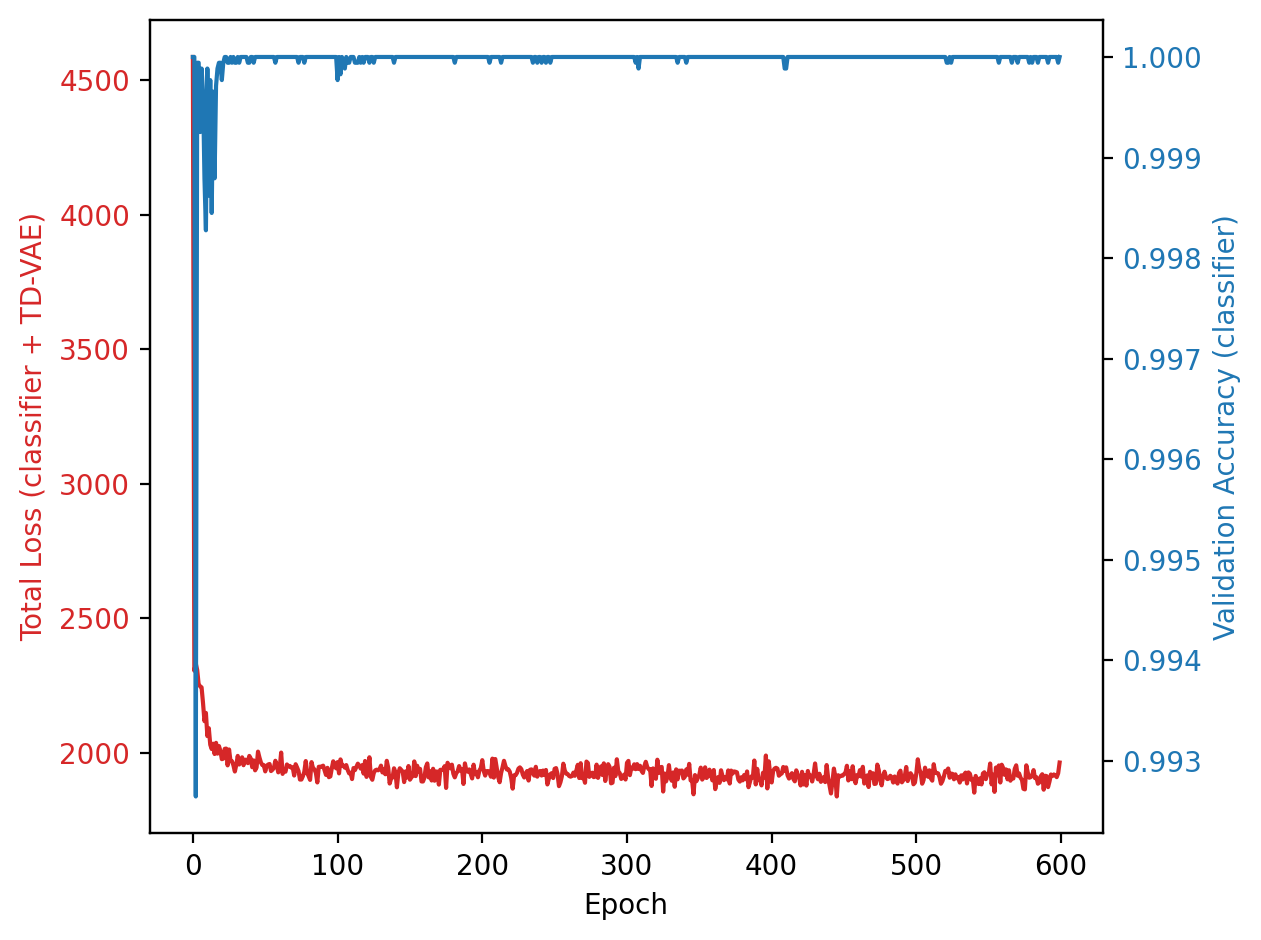

In [35]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss (classifier + TD-VAE)', color=color)
ax1.plot(log.index, log['tloss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy (classifier)', color=color)  # we already handled the x-label with ax1
ax2.plot(log.index, log['val_acc'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Continue

In [36]:
del(data)
del(dataset)
del(loader)
del(train_dataset)
del(train_loader)
del(val_dataset)
del(val_loader)
del(model)

In [37]:
with open("./genesys_root_data.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
    
batch_size = 512
dataset = Root_Dataset(data['X_test'], data['y_test'])
loader = DataLoader(dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
train_dataset = Root_Dataset(data['X_train'], data['y_train'])
train_loader = DataLoader(train_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
val_dataset = Root_Dataset(data['X_val'], data['y_val'])
val_loader = DataLoader(val_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)

In [38]:
criterion = torch.nn.NLLLoss()
input_size = data['X_train'].shape[1]
## 10 cell types
output_size = 10
time_bins = 11
embedding_dim = 256
hidden_dim = 256
n_layers = 2
clip = 5
path = "./"
device = "cuda"
n_epochs = 100
train_on_gpu=True

In [39]:
model = ClassifierLSTM(input_size, output_size, embedding_dim, hidden_dim, n_layers).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
sch = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, threshold=0.05, verbose=True)

In [40]:
checkpoint = torch.load(path+"./genesys_model_trained_on_root_atlas_20240308_continue5.pth")
model.load_state_dict(checkpoint)

FileNotFoundError: [Errno 2] No such file or directory: '././genesys_model_trained_on_root_atlas_20240308_continue5.pth'

In [ ]:
# Load previous logger
with open('log_genesys_model_trained_on_root_atlas_20240308_continue5.pkl', 'rb') as f:
        logger = pickle.load(f)

In [ ]:
min(logger['tloss'])

In [ ]:
#logger = {'tloss': [], 'val_acc': []}
#best_val_acc = 0.99
best_loss = min(logger['tloss'])
for epoch in range(n_epochs):
    h = model.init_hidden(batch_size)
    c, s = 0, 0
    pBar = tqdm(train_loader)
    model.train()
    for sample in pBar:
        h = tuple([each.data for each in h])
        x = sample['x'].to(device)
        y = sample['y'].to(device)
        optimizer.zero_grad()
        t = np.random.choice(time_bins-1)
        p, h = model.predict(x, h, t)
        model.get_belief(x, h)
        tdvae_loss = model.calculate_loss(t)
        nll_loss = criterion(p, y)
        loss = tdvae_loss + nll_loss
        # print(loss)
        s = ((s*c)+(float(loss.item())*len(p)))/(c+len(p))
        c += len(p)
        pBar.set_description('Epoch {} Train: '.format(epoch) +str(round(float(s),4)))
        wl = np.random.choice(2)
        if wl == 0 :
            tdvae_loss.backward()
        else :
            nll_loss.backward()
        #loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    logger['tloss'].append(s)
    sch.step(s)

    val_h = model.init_hidden(batch_size)
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for sample in val_loader:
            val_h = tuple([each.data for each in val_h])
            x = sample['x'].to(device)
            y = sample['y'].to(device)
            #t = np.random.choice(11)
            t=1
            p, val_h = model.predict_proba(x, val_h, t)
            y_pred.append(p.cpu().detach().numpy())
            y_true.append(y.cpu().detach().numpy())
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)

    val_acc = (y_true == y_pred.argmax(axis=1)).mean()
    logger['val_acc'].append(val_acc)
    print("Validation Accuracy {:.4f}".format(val_acc))
    if (val_acc >= 0.99) & (s < best_loss):
        # print('Model improved')
        #best_val_acc = val_acc
        best_loss = s
        print(best_loss)
        torch.save(model.state_dict(), path+"/genesys_model_trained_on_root_atlas_20240308_continue6.pth")
        val_stats = {'pred': y_pred, 'true': y_true}

with open('log_genesys_model_trained_on_root_atlas_20240308_continue6.pkl', 'wb') as f:
    pickle.dump(logger, f)
#if cmat:
    # Plot validation confusion matrix
#    self.plot_cfmt(self.val_stats['pred'], self.val_stats['true'], 0.05, 'val_cfmt.pdf')

In [ ]:
print(best_loss)

In [ ]:
log = pd.DataFrame(logger)
log.to_csv("log_root_atlas_20240308_continue6.csv")
log = pd.read_csv("log_root_atlas_20240308_continue6.csv", index_col=0)

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss (classifier + TD-VAE)', color=color)
ax1.plot(log.index, log['tloss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy (classifier)', color=color)  # we already handled the x-label with ax1
ax2.plot(log.index, log['val_acc'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Continue

In [ ]:
del(data)
del(dataset)
del(loader)
del(train_dataset)
del(train_loader)
del(val_dataset)
del(val_loader)
del(model)

In [ ]:
with open("./genesys_root_data.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
    
batch_size = 512
dataset = Root_Dataset(data['X_test'], data['y_test'])
loader = DataLoader(dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
train_dataset = Root_Dataset(data['X_train'], data['y_train'])
train_loader = DataLoader(train_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
val_dataset = Root_Dataset(data['X_val'], data['y_val'])
val_loader = DataLoader(val_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)

In [ ]:
criterion = torch.nn.NLLLoss()
input_size = data['X_train'].shape[1]
## 10 cell types
output_size = 10
time_bins = 11
embedding_dim = 256
hidden_dim = 256
n_layers = 2
clip = 5
path = "./"
device = "cuda"
n_epochs = 100
train_on_gpu=True

In [ ]:
model = ClassifierLSTM(input_size, output_size, embedding_dim, hidden_dim, n_layers).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
sch = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, threshold=0.05, verbose=True)

In [ ]:
checkpoint = torch.load(path+"./genesys_model_trained_on_root_atlas_20240308_continue6.pth")
model.load_state_dict(checkpoint)

In [ ]:
# Load previous logger
with open('log_genesys_model_trained_on_root_atlas_20240308_continue6.pkl', 'rb') as f:
        logger = pickle.load(f)

In [ ]:
min(logger['tloss'])

In [ ]:
#logger = {'tloss': [], 'val_acc': []}
#best_val_acc = 0.99
best_loss = min(logger['tloss'])
for epoch in range(n_epochs):
    h = model.init_hidden(batch_size)
    c, s = 0, 0
    pBar = tqdm(train_loader)
    model.train()
    for sample in pBar:
        h = tuple([each.data for each in h])
        x = sample['x'].to(device)
        y = sample['y'].to(device)
        optimizer.zero_grad()
        t = np.random.choice(time_bins-1)
        p, h = model.predict(x, h, t)
        model.get_belief(x, h)
        tdvae_loss = model.calculate_loss(t)
        nll_loss = criterion(p, y)
        loss = tdvae_loss + nll_loss
        # print(loss)
        s = ((s*c)+(float(loss.item())*len(p)))/(c+len(p))
        c += len(p)
        pBar.set_description('Epoch {} Train: '.format(epoch) +str(round(float(s),4)))
        wl = np.random.choice(2)
        if wl == 0 :
            tdvae_loss.backward()
        else :
            nll_loss.backward()
        #loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    logger['tloss'].append(s)
    sch.step(s)

    val_h = model.init_hidden(batch_size)
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for sample in val_loader:
            val_h = tuple([each.data for each in val_h])
            x = sample['x'].to(device)
            y = sample['y'].to(device)
            #t = np.random.choice(11)
            t=1
            p, val_h = model.predict_proba(x, val_h, t)
            y_pred.append(p.cpu().detach().numpy())
            y_true.append(y.cpu().detach().numpy())
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)

    val_acc = (y_true == y_pred.argmax(axis=1)).mean()
    logger['val_acc'].append(val_acc)
    print("Validation Accuracy {:.4f}".format(val_acc))
    if (val_acc >= 0.99) & (s < best_loss):
        # print('Model improved')
        #best_val_acc = val_acc
        best_loss = s
        print(best_loss)
        torch.save(model.state_dict(), path+"/genesys_model_trained_on_root_atlas_20240308_continue7.pth")
        val_stats = {'pred': y_pred, 'true': y_true}

with open('log_genesys_model_trained_on_root_atlas_20240308_continue7.pkl', 'wb') as f:
    pickle.dump(logger, f)
#if cmat:
    # Plot validation confusion matrix
#    self.plot_cfmt(self.val_stats['pred'], self.val_stats['true'], 0.05, 'val_cfmt.pdf')

In [ ]:
print(best_loss)

In [ ]:
log = pd.DataFrame(logger)
log.to_csv("log_root_atlas_20240308_continue7.csv")
log = pd.read_csv("log_root_atlas_20240308_continue7.csv", index_col=0)

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss (classifier + TD-VAE)', color=color)
ax1.plot(log.index, log['tloss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy (classifier)', color=color)  # we already handled the x-label with ax1
ax2.plot(log.index, log['val_acc'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Continue

In [ ]:
del(data)
del(dataset)
del(loader)
del(train_dataset)
del(train_loader)
del(val_dataset)
del(val_loader)
del(model)

In [ ]:
with open("./genesys_root_data.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
    
batch_size = 512
dataset = Root_Dataset(data['X_test'], data['y_test'])
loader = DataLoader(dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
train_dataset = Root_Dataset(data['X_train'], data['y_train'])
train_loader = DataLoader(train_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
val_dataset = Root_Dataset(data['X_val'], data['y_val'])
val_loader = DataLoader(val_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)

In [ ]:
criterion = torch.nn.NLLLoss()
input_size = data['X_train'].shape[1]
## 10 cell types
output_size = 10
time_bins = 11
embedding_dim = 256
hidden_dim = 256
n_layers = 2
clip = 5
path = "./"
device = "cuda"
n_epochs = 100
train_on_gpu=True

In [ ]:
model = ClassifierLSTM(input_size, output_size, embedding_dim, hidden_dim, n_layers).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
sch = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, threshold=0.05, verbose=True)

In [ ]:
checkpoint = torch.load(path+"./genesys_model_trained_on_root_atlas_20240308_continue7.pth")
model.load_state_dict(checkpoint)

In [ ]:
# Load previous logger
with open('log_genesys_model_trained_on_root_atlas_20240308_continue7.pkl', 'rb') as f:
        logger = pickle.load(f)

In [ ]:
min(logger['tloss'])

In [ ]:
#logger = {'tloss': [], 'val_acc': []}
#best_val_acc = 0.99
best_loss = min(logger['tloss'])
for epoch in range(n_epochs):
    h = model.init_hidden(batch_size)
    c, s = 0, 0
    pBar = tqdm(train_loader)
    model.train()
    for sample in pBar:
        h = tuple([each.data for each in h])
        x = sample['x'].to(device)
        y = sample['y'].to(device)
        optimizer.zero_grad()
        t = np.random.choice(time_bins-1)
        p, h = model.predict(x, h, t)
        model.get_belief(x, h)
        tdvae_loss = model.calculate_loss(t)
        nll_loss = criterion(p, y)
        loss = tdvae_loss + nll_loss
        # print(loss)
        s = ((s*c)+(float(loss.item())*len(p)))/(c+len(p))
        c += len(p)
        pBar.set_description('Epoch {} Train: '.format(epoch) +str(round(float(s),4)))
        wl = np.random.choice(2)
        if wl == 0 :
            tdvae_loss.backward()
        else :
            nll_loss.backward()
        #loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    logger['tloss'].append(s)
    sch.step(s)

    val_h = model.init_hidden(batch_size)
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for sample in val_loader:
            val_h = tuple([each.data for each in val_h])
            x = sample['x'].to(device)
            y = sample['y'].to(device)
            #t = np.random.choice(11)
            t=1
            p, val_h = model.predict_proba(x, val_h, t)
            y_pred.append(p.cpu().detach().numpy())
            y_true.append(y.cpu().detach().numpy())
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)

    val_acc = (y_true == y_pred.argmax(axis=1)).mean()
    logger['val_acc'].append(val_acc)
    print("Validation Accuracy {:.4f}".format(val_acc))
    if (val_acc >= 0.99) & (s < best_loss):
        # print('Model improved')
        #best_val_acc = val_acc
        best_loss = s
        print(best_loss)
        torch.save(model.state_dict(), path+"/genesys_model_trained_on_root_atlas_20240308_continue8.pth")
        val_stats = {'pred': y_pred, 'true': y_true}

with open('log_genesys_model_trained_on_root_atlas_20240308_continue8.pkl', 'wb') as f:
    pickle.dump(logger, f)
#if cmat:
    # Plot validation confusion matrix
#    self.plot_cfmt(self.val_stats['pred'], self.val_stats['true'], 0.05, 'val_cfmt.pdf')

In [ ]:
print(best_loss)

In [ ]:
log = pd.DataFrame(logger)
log.to_csv("log_root_atlas_20240308_continue8.csv")
log = pd.read_csv("log_root_atlas_20240308_continue8.csv", index_col=0)

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss (classifier + TD-VAE)', color=color)
ax1.plot(log.index, log['tloss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy (classifier)', color=color)  # we already handled the x-label with ax1
ax2.plot(log.index, log['val_acc'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Continue

In [ ]:
del(data)
del(dataset)
del(loader)
del(train_dataset)
del(train_loader)
del(val_dataset)
del(val_loader)
del(model)

In [ ]:
with open("./genesys_root_data.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
    
batch_size = 512
dataset = Root_Dataset(data['X_test'], data['y_test'])
loader = DataLoader(dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
train_dataset = Root_Dataset(data['X_train'], data['y_train'])
train_loader = DataLoader(train_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
val_dataset = Root_Dataset(data['X_val'], data['y_val'])
val_loader = DataLoader(val_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)

In [ ]:
criterion = torch.nn.NLLLoss()
input_size = data['X_train'].shape[1]
## 10 cell types
output_size = 10
time_bins = 11
embedding_dim = 256
hidden_dim = 256
n_layers = 2
clip = 5
path = "./"
device = "cuda"
n_epochs = 100
train_on_gpu=True

In [ ]:
model = ClassifierLSTM(input_size, output_size, embedding_dim, hidden_dim, n_layers).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
sch = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, threshold=0.05, verbose=True)

In [ ]:
checkpoint = torch.load(path+"./genesys_model_trained_on_root_atlas_20240308_continue8.pth")
model.load_state_dict(checkpoint)

In [ ]:
# Load previous logger
with open('log_genesys_model_trained_on_root_atlas_20240308_continue8.pkl', 'rb') as f:
        logger = pickle.load(f)

In [ ]:
min(logger['tloss'])

In [ ]:
#logger = {'tloss': [], 'val_acc': []}
#best_val_acc = 0.99
best_loss = min(logger['tloss'])
for epoch in range(n_epochs):
    h = model.init_hidden(batch_size)
    c, s = 0, 0
    pBar = tqdm(train_loader)
    model.train()
    for sample in pBar:
        h = tuple([each.data for each in h])
        x = sample['x'].to(device)
        y = sample['y'].to(device)
        optimizer.zero_grad()
        t = np.random.choice(time_bins-1)
        p, h = model.predict(x, h, t)
        model.get_belief(x, h)
        tdvae_loss = model.calculate_loss(t)
        nll_loss = criterion(p, y)
        loss = tdvae_loss + nll_loss
        # print(loss)
        s = ((s*c)+(float(loss.item())*len(p)))/(c+len(p))
        c += len(p)
        pBar.set_description('Epoch {} Train: '.format(epoch) +str(round(float(s),4)))
        wl = np.random.choice(2)
        if wl == 0 :
            tdvae_loss.backward()
        else :
            nll_loss.backward()
        #loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    logger['tloss'].append(s)
    sch.step(s)

    val_h = model.init_hidden(batch_size)
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for sample in val_loader:
            val_h = tuple([each.data for each in val_h])
            x = sample['x'].to(device)
            y = sample['y'].to(device)
            #t = np.random.choice(11)
            t=1
            p, val_h = model.predict_proba(x, val_h, t)
            y_pred.append(p.cpu().detach().numpy())
            y_true.append(y.cpu().detach().numpy())
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)

    val_acc = (y_true == y_pred.argmax(axis=1)).mean()
    logger['val_acc'].append(val_acc)
    print("Validation Accuracy {:.4f}".format(val_acc))
    if (val_acc >= 0.99) & (s < best_loss):
        # print('Model improved')
        #best_val_acc = val_acc
        best_loss = s
        print(best_loss)
        torch.save(model.state_dict(), path+"/genesys_model_trained_on_root_atlas_20240308_continue9.pth")
        val_stats = {'pred': y_pred, 'true': y_true}

with open('log_genesys_model_trained_on_root_atlas_20240308_continue9.pkl', 'wb') as f:
    pickle.dump(logger, f)
#if cmat:
    # Plot validation confusion matrix
#    self.plot_cfmt(self.val_stats['pred'], self.val_stats['true'], 0.05, 'val_cfmt.pdf')

In [ ]:
print(best_loss)

In [ ]:
log = pd.DataFrame(logger)
log.to_csv("log_root_atlas_20240308_continue9.csv")
log = pd.read_csv("log_root_atlas_20240308_continue9.csv", index_col=0)

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss (classifier + TD-VAE)', color=color)
ax1.plot(log.index, log['tloss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy (classifier)', color=color)  # we already handled the x-label with ax1
ax2.plot(log.index, log['val_acc'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Plot the log

In [43]:
log = pd.read_csv("log_root_atlas_20240308_continue5.csv", index_col=0)

In [153]:
#log.index= range(600)

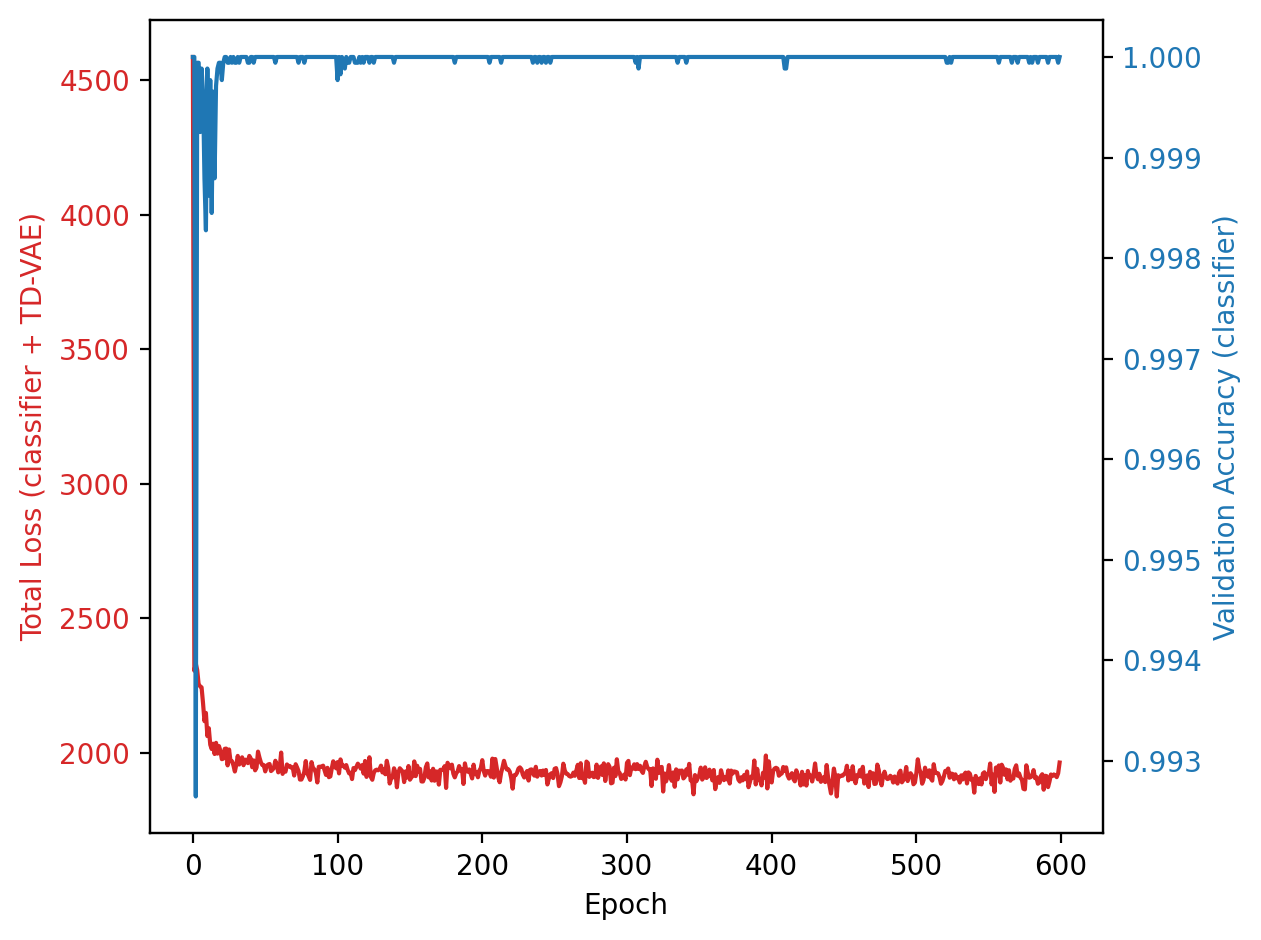

In [44]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss (classifier + TD-VAE)', color=color)
ax1.plot(log.index, log['tloss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy (classifier)', color=color)  # we already handled the x-label with ax1
ax2.plot(log.index, log['val_acc'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [45]:
log = log[1:600]

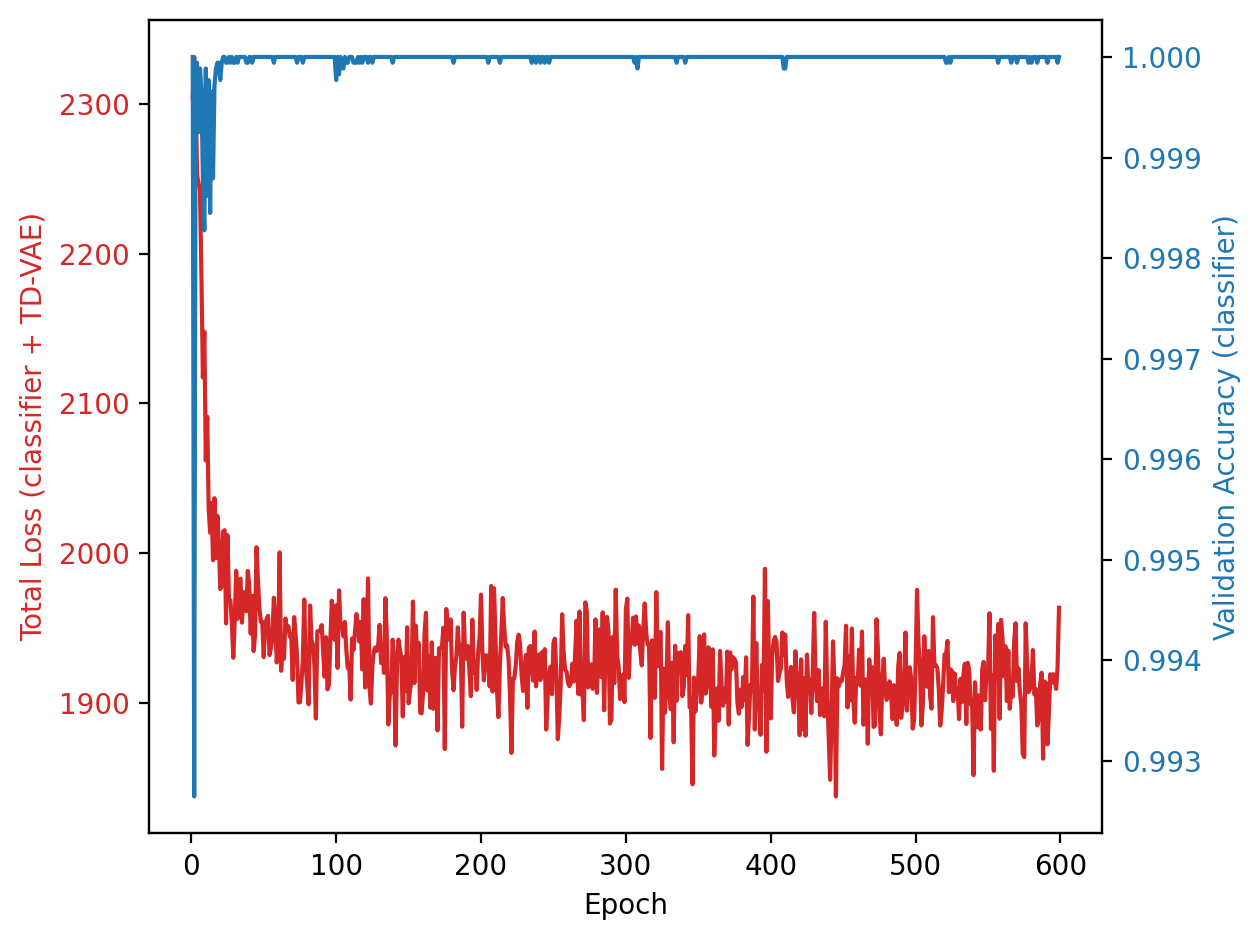

In [46]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss (classifier + TD-VAE)', color=color)
ax1.plot(log.index, log['tloss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy (classifier)', color=color)  # we already handled the x-label with ax1
ax2.plot(log.index, log['val_acc'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()